This notebook estimates the number of V100 GPU-days used to train our adversaries.

Also has plots of evals over the course of adversarial fine-tuning.

In [1]:
%load_ext autoreload
%autoreload 2
import collections
import datetime
import json
import os
import pprint
import re
import warnings
from pathlib import Path
from typing import Callable, Iterable, Mapping, Sequence

import dateutil.parser
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler
from statsmodels.stats.proportion import proportion_confint

import utils

HOURS_TO_SECONDS = 60 * 60
DAYS_TO_SECONDS = 24 * 60 * 60
# Estimate of how many V100 GPU-days is 1 A6000 GPU-day using this data:
# https://www.notion.so/chaiberkeley/Benchmark-KataGo-victimplay-on-different-hardware-295ac2d430404430b8a1e0232f72b240
# - On cp505, 3 A6000 victimplay workers generated 250k rows in 9h30m and 7
#   V100 workers generated 250k rows in 6h44m. This corresponds to an A6000 worker
#   being 1.6538x faster.
# - On cp127, 3 A6000 workers generated 1002027 rows in 16h03 and 7 V100 workers
#   generated 1019074 rows in 12h16. This corresponds to an A6000 worker being
#   1.7535x faster.
# - The mean of 1.6537 and 1.7535 is 1.7036.
#
# Comparison:
# - At https://lambdalabs.com/gpu-benchmarks with fp16 precision,
#   Lambda measures the conversion factor to be 1.48.
A6000_TO_V100_GPU_DAY = 1.703643

VICTIMPLAY_PATH = "/shared/victimplay"
TIME_ZONE = datetime.timezone.utc  # assume all timestamps are UTC

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col-neurips"),
        utils.get_style("small-legend"),
    ]
)
utils.import_plt_sty("robustness-macros.sty")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
three_column_width = plt.rcParams['figure.figsize'][0] * 0.32
# Style for small 3-column plots
three_column_style = {
    "figure.figsize": (three_column_width, three_column_width),
    "font.size": 5,
    "legend.fontsize": 5,
    "axes.labelpad": 2,
    "ytick.right": False,
}
for c in ["x", "y"]:
    three_column_style.update({
        f"{c}tick.major.size": 2.4,
        f"{c}tick.minor.size": 1.5,
        f"{c}tick.major.pad": 1.5,
        f"{c}tick.minor.pad": 1.4,
        f"{c}tick.minor.visible": True,
    })

## Conversions to A6000 GPU-days

Our adversaries were trained using A6000, A4000, A100 40GB,
and A100 80GB GPUs. We'll estimate how many A6000 GPU-days is
1 GPU-day on each of these GPU types.

In [3]:
def get_play_log_line_timestamp(line: str) -> datetime.datetime | None:
    """Fetches the timestamp from a line in a selfplay/victimplay log file."""
    match = re.match(r"([0-9 \-+:]+): ", line)
    if match is None:
        return None
    return dateutil.parser.parse(match.group(1))


def get_victimplay_games_finished(log_filename: Path, game_limit=None) -> int:
    """Returns the number of games the victimplay worker completed.

    Args:
        log_filename: Filename of the victimplay worker's log file.
        game_limit: If not None, then stop counting and return early if
          this number of games is reached.
    """
    GAME_FINISH_REGEX = re.compile("Game #")
    num_games_finished = 0
    with open(log_filename, "r") as f:
        for line in f:
            if GAME_FINISH_REGEX.search(line) is not None:
                num_games_finished += 1
                if game_limit is not None and num_games_finished >= game_limit:
                    break
    return num_games_finished


def get_victimplay_gpu_type(log_filename: Path) -> str | None:
    """Parses GPU type from victimplay log."""
    GPU_TYPE_REGEX = re.compile(r"Found GPU (.*) memory")
    with open(log_filename, "r") as f:
        for line in f:
            match = GPU_TYPE_REGEX.search(line)
            if match is not None:
                return match.group(1)
    return None


def get_victimplay_num_gpus(log_filename: Path) -> int:
    """Parses the number of GPUs used from victimplay log."""
    GAME_START_REGEX = re.compile(r"starting game")
    GPU_INDEX_REGEX = re.compile(r"[Dd]eviceToUse[A-Za-z0-9]* = (\d+)")
    gpu_indices = set()
    with open(log_filename, "r") as f:
        for line in f:
            gpu_index_match = GPU_INDEX_REGEX.search(line)
            if gpu_index_match is not None:
                gpu_indices.add(gpu_index_match.group(1))

            if GAME_START_REGEX.search(line) is not None:
                break
    return len(gpu_indices)

In [4]:
def get_victimplay_duration(log_filename: Path) -> float | None:
    """Returns how long the victimplay worker was generating games.

    Args:
      log_filename: Filename of the victimplay worker's log file.

    Returns:
        How long the worker was generating games in seconds.
        Returns None if the worker did not generate any games.
    """
    GAME_START_REGEX = re.compile(r"starting game")
    TIMESTAMP_REGEX = re.compile(r"([0-9 \-+:]+): ")
    with open(log_filename, "r") as f:
        first_game_start_timestamp = None
        for line in f:
            if GAME_START_REGEX.search(line) is not None:
                first_game_start_timestamp = get_play_log_line_timestamp(line)
                assert first_game_start_timestamp is not None
                break
        if first_game_start_timestamp is None:
            return None

        for line in f:
            pass
        last_line = line
        last_timestamp = get_play_log_line_timestamp(last_line)
        assert last_timestamp is not None
        return (last_timestamp - first_game_start_timestamp).total_seconds()

# Benchmarking H100 vs A6000 victimplay workers that have run for similar amount of times
benchmarking_directories = [
    "/shared/victimplay/ttseng-attack-b18-cont-movelimitneg-240304/benchmark/h100",
    "/shared/victimplay/ttseng-attack-b18-cont-movelimitneg-240304/benchmark/a6000",
]

# We'll count the number of games each victimplay worker completed
# as a proxy for how performant the GPU type is for our workload.

# Key = GPU type
# Value = List of number of victimplay games per hour
#        (1 entry for each victimplay worker)
gpu_type_to_game_throughputs = collections.defaultdict(list)
for directory in benchmarking_directories:
    victimplay_logfiles = Path(directory).glob(f"log*.log")
    for logfile in victimplay_logfiles:
        assert get_victimplay_num_gpus(logfile) == 1
        duration = get_victimplay_duration(logfile)
        if duration is None:
            continue
        gpu_type = get_victimplay_gpu_type(logfile)
        assert gpu_type is not None
        games_finished = get_victimplay_games_finished(logfile)
        throughput = games_finished / (duration / HOURS_TO_SECONDS)
        gpu_type_to_game_throughputs[gpu_type].append(throughput)

gpu_type_to_avg_throughput = {}
for gpu_type, throughputs in gpu_type_to_game_throughputs.items():
    avg = np.mean(throughputs)
    stddev = np.std(throughputs)
    print(f"{gpu_type} throughput: Avg. {avg} +- {stddev}")
    gpu_type_to_avg_throughput[gpu_type] = avg

a6000_throughput = gpu_type_to_avg_throughput["NVIDIA RTX A6000"]
# Key = GPU type
# Value = Estimate of how many A6000 GPU-days is 1 GPU-day
#         of this GPU type.
gpu_type_to_a6000_gpu_days = {
    gpu_type: throughput / a6000_throughput
    for gpu_type, throughput in gpu_type_to_avg_throughput.items()
}

print("Conversions to A6000 GPU-days:")
pprint.pprint(gpu_type_to_a6000_gpu_days)

NVIDIA H100 80GB HBM3 throughput: Avg. 22.232815892279323 +- 0.3437091674123699
NVIDIA RTX A6000 throughput: Avg. 48.62807543026482 +- 3.657000153493275
Conversions to A6000 GPU-days:
{'NVIDIA H100 80GB HBM3': 0.4572012298566562, 'NVIDIA RTX A6000': 1.0}


In [5]:
# copied from estimate-gpu-days-adv.ipynb
gpu_type_to_a6000_gpu_days.update({
    'NVIDIA A100-SXM4-40GB': 1.6694291990282832,
    'NVIDIA A100-SXM4-80GB': 1.8728189715108867,
    'NVIDIA RTX A4000': 0.6267341190128057,
    'NVIDIA RTX A6000': 1.0
})

## V100 GPU-days used for training adversaries

In [6]:
def get_modified_time(filename: Path) -> datetime.datetime:
    """Returns the modified time of a file."""
    epoch_time = os.path.getmtime(filename)
    return datetime.datetime.fromtimestamp(epoch_time, tz=TIME_ZONE)


def get_adversary_modified_time(
    training_path: Path,
    adversary_steps: int,
) -> datetime.datetime:
    """Returns when the adversary model file was modified."""
    adversary_files = list(
        training_path.glob(f"models/t0-s{adversary_steps}-d*/model.bin.gz")
    ) + list(
        training_path.glob(f"models/t0-s{adversary_steps}-d*/model.pt")
    )
    assert len(adversary_files) == 1, adversary_files
    return get_modified_time(adversary_files[0])


def get_adversary_written_times(
    training_path: Path,
    adversary_steps_list: Iterable[int],
    trust_last_modified_timestamps: bool,
) -> list[datetime.datetime]:
    """Returns adversary model file written time for each adversary step count.

    Args:
        training_path: Output directory of the adversary's training run.
        adversary_steps_list: List of adversary training steps at which to
            compute GPU-days. Must be sorted in ascending order.
        trust_last_modified_timestamps: Whether to assume last-modified
          timestamps of models are accurate (i.e., represent the time training 
          run generated the file).
    """
    assert adversary_steps_list == sorted(adversary_steps_list)
    if trust_last_modified_timestamps:
        adversary_written_times = [
            get_adversary_modified_time(training_path, steps)
            for steps in adversary_steps_list
        ]
    else:
        # Look through victimplay logs for when models appeared.
        # (It would be faster to use train logs, but for h1--h4 which we
        # ported over from Hofvarpnir (now inaccessible), we don't 
        # have the train logs.)
        adversary_written_times = [None for _ in adversary_steps_list]
        MODEL_REGEX = re.compile(r"(?:Data write loop starting for neural net: t0-s|Found new neural net t0-s)(\d+)-d")
        victimplay_logfiles = training_path.glob("selfplay/log*.log")
        for logfile in victimplay_logfiles:
            with open(logfile) as f:
                for line in f:
                    match = MODEL_REGEX.search(line)
                    if match:
                        match_steps = int(match.group(1))
                        for i, adv_steps in enumerate(adversary_steps_list):
                            if match_steps != adv_steps:
                                continue
                            timestamp = get_play_log_line_timestamp(line)
                            adversary_written_times[i] = (
                                timestamp if adversary_written_times[i] is None
                                else min(timestamp, adversary_written_times[i])
                            )
        assert None not in adversary_written_times
    assert adversary_written_times == sorted(adversary_written_times)
    return adversary_written_times


def get_play_gpu_seconds(
    training_path: Path,
    adversary_steps_list: Iterable[int],
    is_victimplay: bool,
    trust_last_modified_timestamps: bool,
) -> list[dict[str, float]]:
    """Returns the GPU-seconds used by the adversary's self-/victim-play workers.

    Args:
        training_path: Output directory of the adversary's training run.
        adversary_steps_list: List of adversary training steps at which to
            compute GPU-days. Must be sorted in ascending order.
        is_victimplay: True if this is victimplay, false if this is selfplay.
        trust_last_modified_timestamps: Whether to assume last-modified
          timestamps of models and victim-/self-play logs are accurate (i.e., 
          represent the  last time the training run modified the file).
    Returns:
        For each step count in adversary_steps, a dictionary mapping GPU
        type to how many GPU-seconds were used of that GPU during victimplay
        to reach that step count.
    """
    CREATION_TIME_REGEX = re.compile(r"log(\d{8}-\d{6})-")

    adversary_written_times = get_adversary_written_times(
        training_path, adversary_steps_list, trust_last_modified_timestamps,
    )
    gpu_type_to_seconds_by_step = [
        collections.defaultdict(int) for _ in adversary_written_times
    ]
    # Lists dicts in gpu_type_to_seconds_by_step (the function's final return value)
    # by decreasing adversary written time.
    adversary_it = list(zip(adversary_written_times, gpu_type_to_seconds_by_step))[::-1]

    victimplay_logfiles = training_path.glob("selfplay/log*.log")
    for logfile in victimplay_logfiles:
        finished_a_game = get_victimplay_games_finished(logfile, game_limit=1) > 0
        if is_victimplay and not finished_a_game:
            # This victimplay worker didn't generate any data, so we'll skip it.
            # E.g., the cyclic-adversary had many workers crash early and not
            # generate any data on Nov. 1 due to a bug.
            # (For selfplay, there's no clean way to definitively determine 
            # whether a worker generated data or not.)
            continue

        # Parse creation time (in UTC) from filename.
        creation_time_match = CREATION_TIME_REGEX.search(logfile.name)
        assert creation_time_match is not None
        creation_time = dateutil.parser.parse(creation_time_match.group(1)).replace(tzinfo=TIME_ZONE)

        gpu_type = get_victimplay_gpu_type(logfile)
        if gpu_type is None:
            # Hack: The GPU type is not printed for the TorchScript backend.
            # But by the time we implemented the TorchScript backend, we were
            # only using A6000s.
            warnings.warn('No GPU type found, assuming A6000')
            gpu_type = "NVIDIA RTX A6000"
        num_gpus = get_victimplay_num_gpus(logfile)
        assert num_gpus > 0

        if trust_last_modified_timestamps:
            modified_time = get_modified_time(logfile)
        else:
            # Get timestamp of logfile's last line.
            with open(logfile) as f:
                for line in f:
                    pass
            modified_time = get_play_log_line_timestamp(line)

        for adversary_written_time, adversary_gpu_type_to_seconds in adversary_it:
            if adversary_written_time <= creation_time:
                # All adversaries beyond this point were written prior to this
                # victimplay worker initializing.
                break
            adversary_gpu_type_to_seconds[gpu_type] += (
                min(modified_time, adversary_written_time) - creation_time
            ).total_seconds() * num_gpus   
            
    return gpu_type_to_seconds_by_step


def get_train_gpu_seconds(
    training_path: Path,
    adversary_steps_list: Iterable[int],
) -> list[dict[str, float]]:
    """Returns the GPU-seconds used by the adversary's train worker."""
    EPOCH_NUMBER_REGEX = re.compile(r"BEGINNING NEXT EPOCH ([0-9]+)")
    TIMESTAMP_REGEX = re.compile(r"Current time: ([0-9 \-+:.]+)")
    MODEL_SAVE_REGEX = re.compile(r"INFO:tensorflow:SavedModel written to: .*/tfsavedmodels_toexport/t0-s(\d+)-d\d+.tmp")
    GPU_REGEX = re.compile(r"name: (.*) major:")

    adversary_steps_list = sorted(adversary_steps_list)
    if len(adversary_steps_list) == 0:
        return []
    if adversary_steps_list[0] <= 0:
        return [collections.defaultdict(int)] + get_train_gpu_seconds(training_path, adversary_steps_list[1:])
    adversary_steps_it = iter(adversary_steps_list)
    adversary_steps = next(adversary_steps_it)
    
    # We'll go through the adversaries by increasing step count. When we hit
    # that step count in the training logs, we're done computing the GPU-seconds 
    # for that adversary and will push the result (accumulated in 
    # gpu_type_to_seconds) into gpu_type_to_seconds_by_step.
    gpu_type_to_seconds_by_step = []
    gpu_type_to_seconds = collections.defaultdict(int)

    # Iterate through the training log file, only incrementing the GPU-seconds
    # when we encounter an epoch in which we trained. A timestamp is printed
    # before and after each epoch.
    train_logfile = training_path / "train" / "t0" / "stdout.txt"
    with open(train_logfile, "r") as f:
        prev_epoch = 0
        prev_timestamp = None
        did_train_this_epoch = False
        gpu_type = None
        for l in f:
            gpu_match = GPU_REGEX.match(l)
            if gpu_match is not None:
                gpu_type = gpu_match.group(1)
            
            model_match = MODEL_SAVE_REGEX.match(l)
            if model_match is not None:
                saved_steps = int(model_match.group(1))
                # We saved a model, which meant we trained
                # bewteen prev_timestamp and the next
                # upcoming timestamp.
                did_train_this_epoch = True

            timestamp_match = TIMESTAMP_REGEX.match(l)
            if timestamp_match is not None:
                timestamp = dateutil.parser.parse(timestamp_match.group(1)).replace(tzinfo=TIME_ZONE)
                if did_train_this_epoch:
                    assert gpu_type is not None
                    while adversary_steps <= saved_steps:
                        adversary_gpu_type_to_seconds = gpu_type_to_seconds.copy()
                        adversary_gpu_type_to_seconds[gpu_type] += (
                            timestamp - prev_timestamp
                        ).total_seconds()
                        gpu_type_to_seconds_by_step.append(
                            adversary_gpu_type_to_seconds
                        )
                        try:
                            adversary_steps = next(adversary_steps_it)
                        except StopIteration:
                            return gpu_type_to_seconds_by_step
                    gpu_type_to_seconds[gpu_type] += (
                        timestamp - prev_timestamp
                    ).total_seconds()
                    did_train_this_epoch = False
                prev_timestamp = timestamp

    # Handle the case where adversary_steps_it is not yet empty This should be rare
    # but could happen if the training run was killed after saving a model and before
    # the next timestamp was printed.
    while True:
        gpu_type_to_seconds_by_step.append(gpu_type_to_seconds.copy())
        try:
            next(adversary_steps_it)
        except StopIteration:
            return gpu_type_to_seconds_by_step


def get_v100_gpu_days(
    training_path: Path,
    adversary_steps_list: Sequence[int],
    is_victimplay: bool = True,
    skip_train = False,
    trust_last_modified_timestamps = True,
    verbose: bool = False,
) -> list[float]:
    """Returns the estimated V100 GPU-days used to train the adversary.

    Args:
        training_path: Output directory of the adversary's training run.
        adversary_steps_list: List of adversary training steps at which to
            compute GPU-days. Must be sorted in ascending order.
        is_victimplay: True if this is victimplay, false if this is selfplay.
        skip_train: True to omit training GPU-days from the result.
        trust_last_modified_timestamps: Whether to assume last-modified
          timestamps of models and victim-/self-play logs are accurate (i.e., 
          represent the  last time the training run modified the file).
        verbose: Whether to print out intermediate calculations.

    Returns:
        For each step count in adversary_steps_list, the estimated V100
        GPU-days to train the adversary for that many steps.
    """
    if len(adversary_steps_list) == 0:
        return []
    if adversary_steps_list[0] == 0:
        return [0.0] + get_v100_gpu_days(
            training_path,
            adversary_steps_list[1:],
            is_victimplay=is_victimplay,
            skip_train=skip_train,
            trust_last_modified_timestamps=trust_last_modified_timestamps,
            verbose=verbose
        )

    play_gpu_usages = get_play_gpu_seconds(
        training_path, adversary_steps_list, is_victimplay, trust_last_modified_timestamps
    )
    train_gpu_usages = (
        [{} for _ in play_gpu_usages]
        if skip_train
        else get_train_gpu_seconds(training_path, adversary_steps_list)
    )
    assert len(play_gpu_usages) == len(train_gpu_usages)

    v100_days_list = []
    for (
        adversary_steps,
        gpu_type_to_play_seconds,
        gpu_type_to_train_seconds,
    ) in zip(adversary_steps_list, play_gpu_usages, train_gpu_usages):
        seconds_dicts = [
            ("play", gpu_type_to_play_seconds),
            ("train", gpu_type_to_train_seconds),
        ]
        v100_days = 0
        for descriptor, seconds_dict in seconds_dicts:
            if verbose:
                days_dict = {
                    gpu_type: seconds / DAYS_TO_SECONDS
                    for gpu_type, seconds in seconds_dict.items()
                }
                print(f"steps={adversary_steps} {descriptor} GPU usage:")
                pprint.pprint(days_dict)
            for gpu_type, seconds in seconds_dict.items():
                days = seconds / DAYS_TO_SECONDS
                v100_days += (
                    days * gpu_type_to_a6000_gpu_days[gpu_type] * A6000_TO_V100_GPU_DAY
                )
        v100_days_list.append(v100_days)
    return v100_days_list

def cached_get_v100_gpu_days(
    training_path: Path,
    is_victimplay: bool = True,
    skip_train = False,
    trust_last_modified_timestamps = True,
    verbose: bool = False,
    force_ignore_cache: bool = False,
) -> dict[int, float]:
    """Returns the estimated V100 GPU-days for each adv checkpoint and caches to disk."""
    selfplay_path = training_path / "selfplay"
    cache_file = selfplay_path / "steps_to_v100_gpu_days.log"
    latest_selfplay_file_mtime = max((log.stat().st_mtime for log in selfplay_path.glob("log*.log")), default=0)
    if force_ignore_cache or not cache_file.exists() or cache_file.stat().st_mtime < latest_selfplay_file_mtime:
        # Cache file doesn't exist, or more training has occurred since the last time cache was populated.
        all_adversary_steps = utils.get_all_adversary_steps(training_path)
        v100_gpu_days_list = get_v100_gpu_days(
            training_path=training_path,
            adversary_steps_list=all_adversary_steps,
            is_victimplay=is_victimplay,
            skip_train=skip_train,
            trust_last_modified_timestamps=trust_last_modified_timestamps,
            verbose=verbose,
        )
        assert(len(all_adversary_steps) == len(v100_gpu_days_list))
        steps_to_gpu_days = dict(zip(all_adversary_steps, v100_gpu_days_list))

        with open(cache_file, "w") as f:
            json.dump(steps_to_gpu_days, f, indent=2)
    with open(cache_file) as f:
        steps_to_gpu_days = json.load(f)
    return { int(steps): gpu_days for steps, gpu_days in steps_to_gpu_days.items()}


def relabel_df_adv(df: pd.DataFrame, adv_name_regex: str = "adv") -> None:
    """Relabels dataframe so that player with name matching the input regex is considered the adversary."""
    adv_is_black = df.b_name.str.contains(adv_name_regex, regex=True)
    adv_is_white = df.w_name.str.contains(adv_name_regex, regex=True)
    assert (~adv_is_black == adv_is_white).all()

    old_adv_is_black = df.adv_name == df.b_name
    old_adv_is_white = df.adv_name == df.w_name
    rows_to_swap = (adv_is_black & old_adv_is_white) | (adv_is_white & old_adv_is_black)

    columns_to_swap = ["color", "name", "visits", "steps", "rsym", "algo"]
    for col in columns_to_swap:
        col1 = f"victim_{col}"
        col2 = f"adv_{col}"
        df.loc[rows_to_swap, col1], df.loc[rows_to_swap, col2] = df.loc[rows_to_swap, col2], df.loc[rows_to_swap, col1]
    columns_to_numerically_negate = ["adv_komi", "adv_minus_victim_score", "adv_minus_victim_score_wo_komi"]
    for col in columns_to_numerically_negate:
        df.loc[rows_to_swap, col] *= -1
    df.loc[rows_to_swap, "adv_win"] ^= True


def cached_get_curriculum_ranges(
    training_path: Path, 
    force_ignore_cache: bool = False,
) -> list(tuple[str, tuple[int, int]]):
    selfplay_path = training_path / "selfplay"
    cache_file = selfplay_path / "curriculum-ranges.log"
    latest_selfplay_file_mtime = max(log.stat().st_mtime for log in selfplay_path.glob("log*.log"))
    if force_ignore_cache or not cache_file.exists() or cache_file.stat().st_mtime < latest_selfplay_file_mtime:
        # Cache file doesn't exist, or more training has occurred since the last time cache was populated.
        training_df = utils.parse_sgfs([str(selfplay_path)], no_victim_okay=False)
        
        # r1's victim has both "adv" and "victim" in the name,
        # so parse_sgfs() mixes up the adversary and victim labels.
        relabel_df_adv(training_df, "t0-s")

        curriculum_ranges = utils.get_victim_active_ranges_allow_repeats(training_df)
        with open(cache_file, "w") as f:
            def np_encoder(object):
                if isinstance(object, np.generic):
                    return object.item()
            # np_encoder tells json.dump how to dump NumPy types.
            # https://stackoverflow.com/a/65151218/4865149
            json.dump(curriculum_ranges, f, default=np_encoder, indent=2)
    with open(cache_file) as f:
        return json.load(f)

In [7]:
# (name, (path, steps)[])
ADVERSARIES = [
    ("Continuous attack", [("ttseng-continuous-attack-230823/", 630461952)]),
    ("attack-b18", [("ttseng-attack-b18-240126", 76005376), ("ttseng-attack-b18-cont-240206", 230596864), ("ttseng-attack-b18-cont-movelimitneg-240304", 216098048)]),
    ("attack h9", [("ttseng-attack-h9-240119", 89110272), ("ttseng-attack-h9-cont-240124", 20176640), ("ttseng-attack-h9-cont-240126", 494445056), ("ttseng-attack-h9-cont-240229", 46917888), ("ttseng-attack-h9-cont-240305", 2067456)]),
    ("attack h9", [("ttseng-attack-h9-240119", 89110272), ("ttseng-attack-h9-cont-240124", 20176640), ("ttseng-attack-h9-cont-240126", 454739200)]),
    ("r1", [("ttseng-cyclic-reattack-20230803", 149878784)]),
    ("r2", [("tony-cyclic-reattack2-20230901", 253266688)]),
    ("r3", [("ttseng-cyclic-r3-20231002", 81496832), ("ttseng-cyclic-r3-20231005", 11976704), ("ttseng-cyclic-r3-20231006-0035", 119860480)]),
    ("r4", [("ttseng-cyclic-r4-20231010", 982983936)]),
    ("r5", [("ttseng-cyclic-r5-20231123", 534912256)]),
    ("r6", [("ttseng-cyclic-r6-20231213", 228355840)]),
    ("r7", [("ttseng-cyclic-r7-20231219", 372472576)]),
    ("r8", [("ttseng-cyclic-r8-20231231", 230162176)]),
    ("r9", [("ttseng-cyclic-r9-20240119", 275431168)]),
    ("attack ViT", [("ttseng-vit-attack-240114", 108951552), ("ttseng-vit-attack-cont-240130", 216829440)]),
]

for name, paths in ADVERSARIES:
    v100_days = 0
    for path, steps in paths:
        v100_days += cached_get_v100_gpu_days(Path(f"{VICTIMPLAY_PATH}/{path}"))[steps]
    print(f"{name} V100 GPU-days:", v100_days)

Continuous attack V100 GPU-days: 1098.4453459036354
attack-b18 V100 GPU-days: 1289.8933094410327
attack h9 V100 GPU-days: 1618.429815709819
attack h9 V100 GPU-days: 1236.9122687439194
r1 V100 GPU-days: 703.2921926351573
r2 V100 GPU-days: 439.2173661375835
r3 V100 GPU-days: 272.65925650076986
r4 V100 GPU-days: 1194.582176655752
r5 V100 GPU-days: 861.7999738081605
r6 V100 GPU-days: 303.9373194278766
r7 V100 GPU-days: 490.70103958463835
r8 V100 GPU-days: 308.00304013666954
r9 V100 GPU-days: 304.79429065862735
attack ViT V100 GPU-days: 1011.2886137447978


In [8]:
print("r0 (original cyclic) V100 GPU-days:", 
    cached_get_v100_gpu_days(
        Path(f"{VICTIMPLAY_PATH}/ttseng-avoid-pass-alive-coldstart-39-20221025-175949"),
        trust_last_modified_timestamps = False,
    )[545065216],
)

r0 (original cyclic) V100 GPU-days: 2223.1665707535462


In [9]:
# We copied h1--h4 from Hofvarpnir from Flamingo and lost their timestamps.
# In addition, we did not port over the training logs, so we do not have a
# training compute estimate.
# Hofvarpnir is now inaccessible so we cannot rectify these issues.
VICTIMS = [
    ("h1", [("ttseng-cp505-advtrain-spp082-lr01-20230728-170008", 61032960)]),
    ("h2", [("ttseng-cp505-h2-20230823-142646", 22387200)]),
    ("h3", [("ttseng-cp505-h3-retry-20230921-202435", 15898624)]),
    ("h4", [("ttseng-cp505-h4-20231009-143230", 10979072)]),
]

for name, paths in VICTIMS:
    v100_days = 0
    for path, steps in paths:
        v100_days += cached_get_v100_gpu_days(
            Path(f"{VICTIMPLAY_PATH}/{path}/iteration-0"),
            skip_train = True,
            trust_last_modified_timestamps = False,
        )[steps]
    print(f"{name} V100 GPU-days:", v100_days)

h1 V100 GPU-days: 56.606161857497575
h2 V100 GPU-days: 14.872327704331783
h3 V100 GPU-days: 9.23158639075689
h4 V100 GPU-days: 7.6448093887470465


In [10]:
VICTIMS = [
    ("h5", [("ttseng-cp505-h5-20231121", 9905920)]),
    ("h6", [("ttseng-cp505-h6-fix-20231212", 19897600)]),
    ("h7", [("ttseng-cp505-h7-20231218", 13333248)]),
    ("h8", [("ttseng-cp505-h8-20231229", 32231168)]),
    ("h9", [("ttseng-cp505-h9-240113", 71170048)]),
]

for name, paths in VICTIMS:
    v100_days = 0
    for path, steps in paths:
        v100_days += cached_get_v100_gpu_days(Path(f"{VICTIMPLAY_PATH}/{path}/iteration-0"))[steps]
    print(f"{name} V100 GPU-days:", v100_days)

h5 V100 GPU-days: 11.830072065790251
h6 V100 GPU-days: 37.74460069290734
h7 V100 GPU-days: 20.320994103272167
h8 V100 GPU-days: 31.951158920259417
h9 V100 GPU-days: 85.1613279947253


In [11]:
VICTIMS = [
    ("ViT", [
        ("ttseng-vitp2b4c384-selfplay-231031", 213218816), 
        ("ttseng-vitp2b8c384-selfplay-231106", 553885440), 
        # ("ttseng-vitp2b16c384-selfplay-231124", 405153792),  # no self-play occurred here
        ("ttseng-vitp2b16c384-minrows10m-240103", 650025472)]
    ),
    ("control b10", [("ttseng-b10-selfplay-231026", 419465984)]),
]

for name, paths in VICTIMS:
    v100_days = 0
    for path, steps in paths:
        v100_days += cached_get_v100_gpu_days(
            Path(f"{VICTIMPLAY_PATH}/{path}"), 
            is_victimplay=False,
            skip_train=True,
    )[steps]
    print(f"{name} V100 GPU-days:", v100_days)
# Train compute estimation doesn't work with Pytorch training, there's no
# timestamp printed after each epoch (well, I added it a bit later, but e.g.,
# it's not present on the ViT-b4 training logs).
# I'll just give some manual estimates, training is a small part of the compute
# cost so I don't care to make an extremely accurate estimate.
#
# Manual estimates:
# b4: 11 A6000 GPU-min/epoch * 211 epochs = 2.746 V100 GPU-days
# b8: 18 A6000 GPU-min/epoch * 546 epochs = 11.627 V100 GPU-days
# b16-231124: 4.5 A6000 GPU-min * 8 GPUs/epoch * 399 epochs
# b16-240103: 4.5 A6000 GPU-min * 8 GPUs/epoch * 95 epochs
#   + 40 A6000 GPU-min * (26 + 113) epochs (first 26 epochs were before the 95 8-GPU epochs)
# b16 total = 27.618 V100 GPU-days
# ViT total = 41.991 V100 GPU-days
#
# control b10: 7 A6000 GPU-min/epoch * 423 epochs = 3.503 V100 GPU-days

ViT V100 GPU-days: 1204.7269729724453
control b10 V100 GPU-days: 117.19763393089711


In [12]:
VICTIMS = [
    ("ViT", [("ttseng-vitp2b4c384-selfplay-231031", 213218816), ("ttseng-vitp2b8c384-selfplay-231106", 553885440), ("ttseng-vitp2b16c384-minrows10m-240103", 650025472)]),
]
for name, paths in VICTIMS:
    v100_days = 0
    for path, steps in paths:
        print(path, "V100 GPU-days:", cached_get_v100_gpu_days(
            Path(f"{VICTIMPLAY_PATH}/{path}"),  
            is_victimplay=False,
            skip_train=True
        )[steps])

ttseng-vitp2b4c384-selfplay-231031 V100 GPU-days: 125.36648480966544
ttseng-vitp2b8c384-selfplay-231106 V100 GPU-days: 649.8186826013052
ttseng-vitp2b16c384-minrows10m-240103 V100 GPU-days: 429.54180556147463


## Adversary win rate vs. GPU-days of training

We use a lot of GPU-days to train the cyclic-adversary, but perhaps it was already
strong earlier in training. Let's plot GPU-days vs. adversary win rate.

In [13]:
def plot_win_rate_vs_gpu_days(
    df: pd.DataFrame,
    training_paths: list[Path],
    victim_name_to_plot_label: Mapping[str, str],
    highlighted_point_step: int,
    adv_name: str,
    stop_steps: list[int | None] = [],
    scale_gpu_days: float | Callable[tuple[int, float], float] = 1.0,
    should_skip_curriculum_change_fn: Callable[int, bool] = lambda _: False,
    y_label: str = r"Adversary win rate \%",
    trust_last_modified_timestamps: bool = True,
    skip_train_compute: bool = False,
    existing_figs: tuple[tuple[matplotlib.figure.Figure, matplotlib.axes.Axes], tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]] | None = None,
    data_background_color: str | None = None,
    verbose: bool = True,
) -> tuple[tuple[matplotlib.figure.Figure, matplotlib.axes.Axes], tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]]:
    """Plots adversary win rate vs. adversary training time.
    First plot has training steps on x-axis, second plot has V100 GPU-days on x-axis.

    Args:
        df: Data of adversary games at various adversary checkpoints.
        training_paths: Output directories of the adversary's training run.
        victim_name_to_plot_label: Key = victims to plot, value = label on plot legend
        highlighted_point_steps: Adversary step count at which to add a highlighted
            point on the resulting plot.
        adv_name: Human-readable name of the adversary.
        stop_steps: stop_steps[i] specifies the step of training_path[i] at which
            training_path[i + 1] was warmstarted.
        scale_gpu_days: Scalar factor by which to scale the GPU-days on the x-axis (for
            runs that used settings that gave bad throughput), or a function
            mapping (steps, original GPU-days) to new GPU-days.
        should_skip_curriculum_change_fn: Function indicating curriculum change step counts to 
            skip drawing on the plot.
        existing_plots: Existing figs/axes on which to append the data (returned by a previous
            call of this function).
        data_background_color: Background color to give to the data plotted in this call to
            this function (intended to be used with existing_plots to demarcate different
            different data sets).
    """
    scale_fn = (lambda _, x: scale_gpu_days * x) if isinstance(scale_gpu_days, (int, float)) else scale_gpu_days
    
    # Get conversion from step count to GPU-days (adv_steps_to_gpu_days).
    adv_steps_to_gpu_days = {}
    cumulative_steps_list = [0]
    cumulative_gpu_days = 0
    stop_steps.extend(None for _ in range(len(training_paths) - len(stop_steps)))
    for i, (path, stop_step) in enumerate(zip(training_paths, stop_steps)):
        path_adv_steps_to_gpu_days = cached_get_v100_gpu_days(
            path,
            trust_last_modified_timestamps=trust_last_modified_timestamps,
            skip_train=skip_train_compute,
        )
        path_max_gpu_days = 0
        for step, gpu_days in path_adv_steps_to_gpu_days.items():
            if stop_step is not None and step > stop_step:
                continue
            cumulative_steps = step + cumulative_steps_list[-1]
            adv_steps_to_gpu_days[cumulative_steps] = (
                scale_fn(cumulative_steps, gpu_days + cumulative_gpu_days)
            )
            path_max_gpu_days = max(path_max_gpu_days, gpu_days)
            
        max_steps = max(adv_steps_to_gpu_days.keys())
        cumulative_steps_list.append(max_steps)
        cumulative_gpu_days += path_max_gpu_days
    steps_list = sorted(df.adv_steps.unique())
    
    # Get steps at which curriculum victim changed.
    curriculum_ranges = []
    for i, (path, stop_step) in enumerate(zip(training_paths, stop_steps)):
        path_curriculum_ranges = cached_get_curriculum_ranges(path)
    
        for victim, (victim_start, victim_end) in sorted(path_curriculum_ranges, key=lambda x: x[1][0]):
            if stop_step is not None:
                if victim_start >= stop_step:
                    continue
                if victim_end >= stop_step:
                    victim_end = stop_step
                
            cumulative_steps = cumulative_steps_list[i]
            if len(curriculum_ranges) > 0 and victim == curriculum_ranges[-1][0]:
                curriculum_ranges[-1] = (victim, (curriculum_ranges[-1][1][0], cumulative_steps + victim_end))
                continue
            curriculum_ranges.append((victim, (cumulative_steps + victim_start, cumulative_steps + victim_end)))
    if verbose:
        print("Curriculum ranges:", curriculum_ranges)
    curriculum_changes_steps = [ victim_start for (victim, (victim_start, victim_end)) in curriculum_ranges ]

    def get_data():
        """Generator of (df, label) of one line of plot data."""
        # Typically we plot separate lines for each victim, but if there are multiple
        # adversary visit counts then we plot separate lines for each adversary instead.
        unique_adv_visits = df['adv_visits'].unique()
        if len(unique_adv_visits) > 1:
            assert len(victim_name_to_plot_label) == 1
            for visits in sorted(unique_adv_visits):
                visits_df = df[df.adv_visits == visits]
                yield visits_df, rf"${adv_name}^\mathrm{{{visits}\,visits}}$"
        else:
            for victim_name, victim_label in victim_name_to_plot_label.items():
                victim_df = df[df.victim_name == victim_name]
                yield victim_df, victim_label

    def plot(
        fig: matplotlib.figure.Figure,
        ax: matplotlib.axes.Axes,
        x_map: Callable[int, int | float],
        x_label: str,
        verbose: bool = False,
    ) -> None:
        """Plots one figure, where x_map transforms adversary steps into x values."""
        # If the fig already contains data, we append our new data
        # to the end.
        x_offset = 0
        for line in ax.lines:
            x_offset = max(x_offset, max(line.get_xdata()))
        xs = [ x_map(steps) + x_offset for steps in steps_list ]
        highlighted_x = x_map(highlighted_point_step) + x_offset

        if data_background_color is not None:
            BACKGROUND_ZORDER = -100
            ax.axvspan(min(xs), max(xs), facecolor=data_background_color, zorder=BACKGROUND_ZORDER)

        for steps in curriculum_changes_steps:
            if steps > 0 and not should_skip_curriculum_change_fn(steps):
                ax.axvline(x=x_map(steps) + x_offset, linestyle=":", linewidth=1, color=COLORS[3])
        
        ALPHA = 0.05
        for i, (sub_df, label) in enumerate(get_data()):
            mean_df = sub_df.groupby("adv_steps").mean(True)
            win_rates = mean_df.adv_win * 100
            assert(len(xs) == len(win_rates))
            x_and_win_rate_rounded = [
                (round(x, 2), round(rate, 2))
                for (x, rate) in zip(xs, win_rates)
            ]
            if verbose:
                print(
                    f"\n(x, win rate) {label}: {x_and_win_rate_rounded}"
                )
            ax.plot(xs, win_rates, label=label, color=COLORS[i])
    
            conf_df = mean_df.apply(
                lambda x: proportion_confint(
                    len(sub_df[(sub_df.adv_steps == x.name) & (sub_df.adv_win)]),
                    len(sub_df[sub_df.adv_steps == int(x.name)]),
                    alpha=ALPHA,
                    # Generate Clopper-Pearson confidence intervals:
                    # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
                    method="beta",
                ),
                axis=1,
                result_type="expand",
            )
            conf_df = conf_df * 100
            ax.fill_between(xs, conf_df[0], conf_df[1], facecolor=COLORS[i], alpha=0.3)
    
            ax.plot(
                highlighted_x,
                win_rates.loc[highlighted_point_step].item(),
                "D",
                color=COLORS[i],
                alpha=0.7,
            )

            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)

    if existing_figs is None:
        fig_steps, ax_steps = plt.subplots(1, 1)
        fig_gpu_days, ax_gpu_days = plt.subplots(1, 1)
    else:
        (fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = existing_figs

    # verbose=False on first call to plot() avoids duplicate verbosity prints
    plot(fig_steps, ax_steps, x_map=lambda x: x, x_label=f"Training steps ({adv_name})", verbose=False)
    plot(fig_gpu_days, ax_gpu_days, x_map=lambda x: adv_steps_to_gpu_days[x], x_label=f"V100 GPU-days of training ({adv_name})", verbose=verbose)

    return (fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days)

Victims: ['b18-s8527m-v4096' 'b18-s8527m-v256']
Curriculum ranges: [('victim-kata1-b18c384nbt-s7283005952-d3602938173-v1', (0, 2067456)), ('victim-kata1-b18c384nbt-s7283005952-d3602938173-v2', (2067456, 4064768)), ('victim-kata1-b18c384nbt-s7283005952-d3602938173-v4', (4064768, 5063168)), ('victim-kata1-b18c384nbt-s7283005952-d3602938173-v8', (5063168, 8058368)), ('victim-kata1-b18c384nbt-s7283005952-d3602938173-v16', (8058368, 9057280)), ('victim-kata1-b18c384nbt-s7312853248-d3610787737-v16', (9057280, 14690560)), ('victim-kata1-b18c384nbt-s7312853248-d3610787737-v32', (14690560, 36510464)), ('victim-kata1-b18c384nbt-s7342816768-d3618704537-v32', (36510464, 37437184)), ('victim-kata1-b18c384nbt-s7342816768-d3618704537-v64', (37437184, 41287680)), ('victim-kata1-b18c384nbt-s7342816768-d3618704537-v128', (41287680, 57406464)), ('victim-kata1-b18c384nbt-s7342816768-d3618704537-v256', (57406464, 63252224)), ('victim-kata1-b18c384nbt-s7372662272-d3626729126-v256', (63252224, 143891712)), (

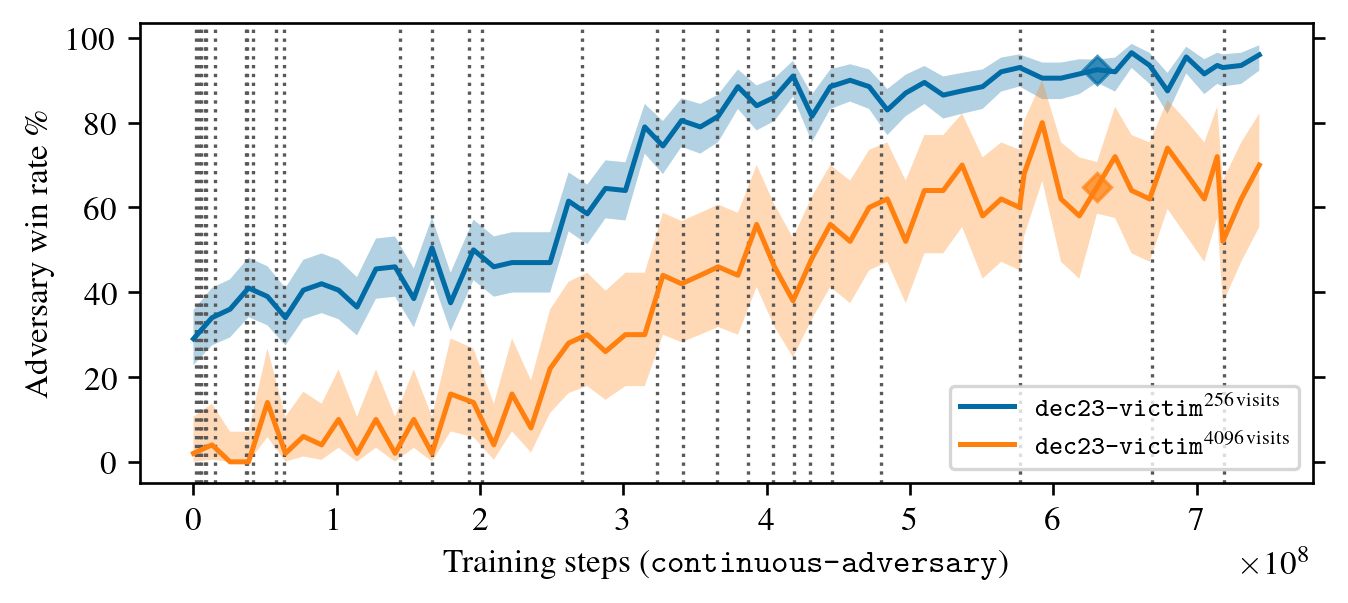

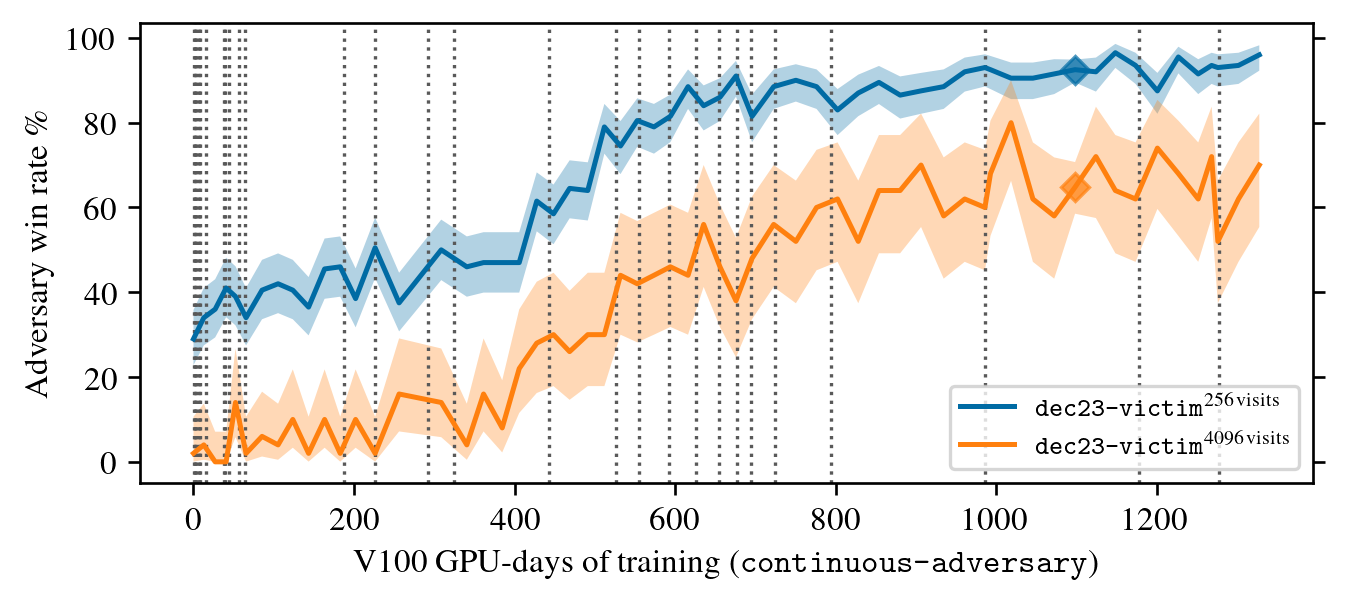

In [14]:
df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-cont-sweeps-240313/adv-ckpts",
    ]
)
print("Victims:", df.victim_name.unique())
(fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = plot_win_rate_vs_gpu_days(
    df,
    [Path("/shared/victimplay/ttseng-continuous-attack-230823")],
    {
        "b18-s8527m-v256": r"$\dectwentythree{}^\mathrm{256\,visits}$",
        "b18-s8527m-v4096": r"$\dectwentythree{}^\mathrm{4096\,visits}$",
    },
    630461952,
    adv_name=r"\contadv{}",
)
ax_steps.legend()
ax_gpu_days.legend()
fig_steps.savefig("win-rate-vs-steps-continuous.pgf", backend="pgf")
fig_gpu_days.savefig("win-rate-vs-gpu-days-continuous.pgf", backend="pgf")

Victims: ['b18-s8527m-v8' 'b18-s8527m-v4096' 'b18-s8527m-v256']
Curriculum ranges: [('victim-kata1-b18c384nbt-s8526915840-d3929217702-v4', (0, 76005376)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v5', (77929472, 77929472)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v4', (78997760, 135533824)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v5', (135533824, 138456832)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v6', (138456832, 182233856)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v7', (182233856, 187011840)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v8', (187011840, 190933760)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v16', (190933760, 194859008)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v32', (194859008, 205628928)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v64', (205628928, 251767040)), ('victim-kata1-b18c384nbt-s8526915840-d3929217702-v128', (251767040, 313729280)), ('victim-kata1-b18c384nbt-s8526915840-d3929

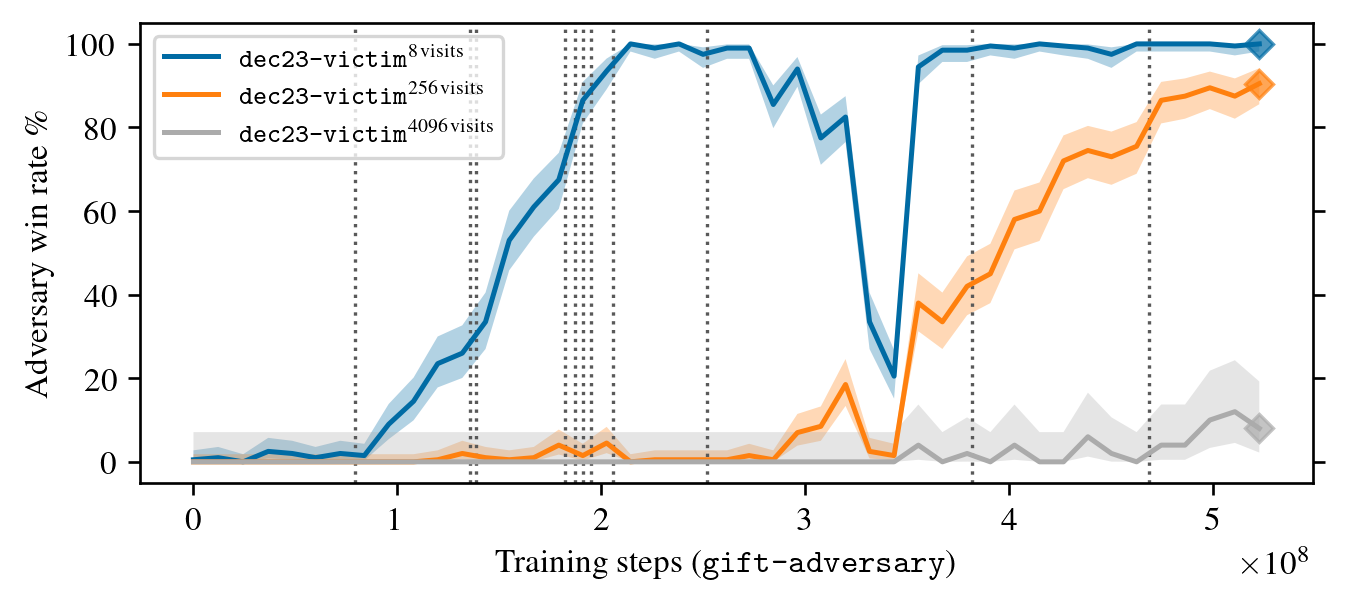

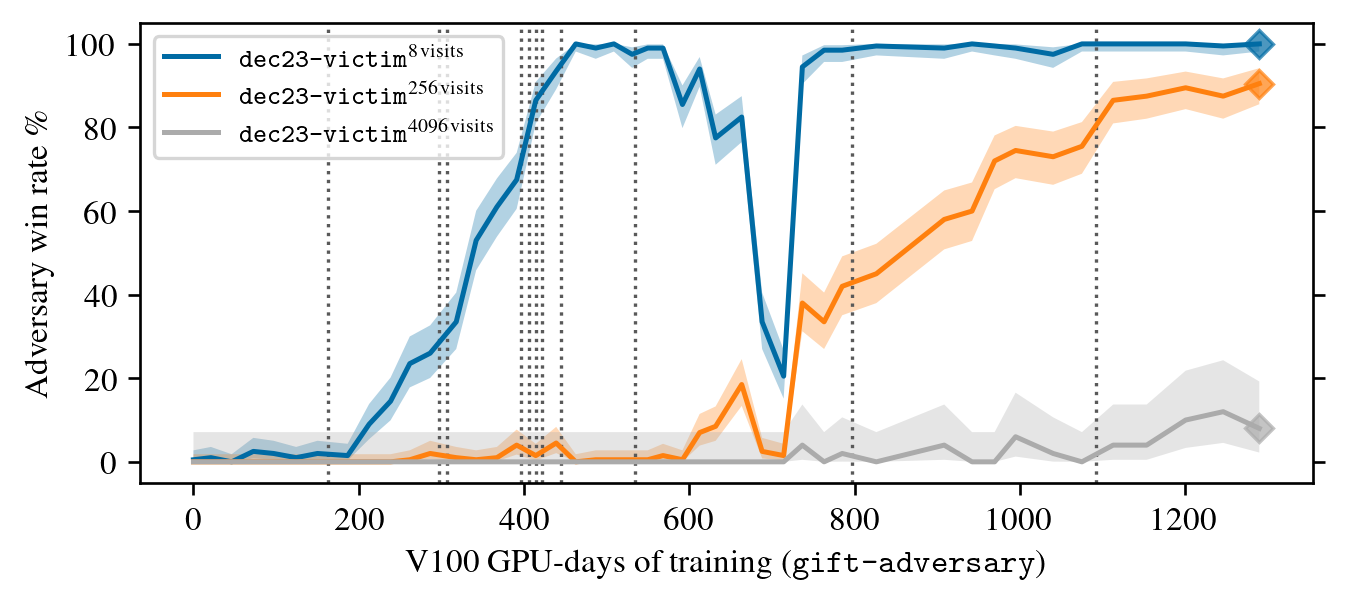

In [15]:
df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-attack-b18-sweeps-240329/adv-ckpts",
    ]
)
print("Victims:", df.victim_name.unique())
(fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = plot_win_rate_vs_gpu_days(
    df,
    [
        (Path("/shared/victimplay/") / path) for path in [
            "ttseng-attack-b18-240126",
            "ttseng-attack-b18-cont-240206",
            "ttseng-attack-b18-cont-movelimitneg-240304",
        ]
    ],
    {
        "b18-s8527m-v8": r"$\dectwentythree{}^\mathrm{8\,visits}$",
        "b18-s8527m-v256": r"$\dectwentythree{}^\mathrm{256\,visits}$",
        "b18-s8527m-v4096": r"$\dectwentythree{}^\mathrm{4096\,visits}$",
    },
    522700288,
    adv_name=r"\koadv",
    stop_steps=[76005376, 230596864],
    # skipping a few premature curriculum jumps
    should_skip_curriculum_change_fn=lambda step: step == 77929472 or 310000000 <= step <= 336000000
)
ax_steps.legend()
ax_gpu_days.legend()
fig_steps.savefig("win-rate-vs-steps-gift.pgf", backend="pgf")
fig_gpu_days.savefig("win-rate-vs-gpu-days-gift.pgf", backend="pgf")

# the win rate tanking is near the start of ttseng-attack-b18-cont-movelimitneg-240304
# when the curriculum prematurely moved to v256 and went down a path of learning to tie
# most games

Victims: ['h9-v1024' 'h9-v256']
Curriculum ranges: [('victim-cp505-h9-s71170048-d121232876-v1', (0, 2138880)), ('victim-cp505-h9-s71170048-d121232876-v2', (2138880, 27369984)), ('victim-cp505-h9-s71170048-d121232876-v4', (27369984, 46044160)), ('victim-cp505-h9-s71170048-d121232876-v8', (46044160, 71355648)), ('victim-cp505-h9-s71170048-d121232876-v16', (71355648, 81339648)), ('victim-cp505-h9-s71170048-d121232876-v32', (81339648, 89110272)), ('victim-cp505-h9-s71170048-d121232876-v64', (89110272, 111208448)), ('victim-cp505-h9-s71170048-d121232876-v128', (111208448, 157904128)), ('victim-cp505-h9-s71170048-d121232876-v256', (157904128, 228061952)), ('victim-cp505-h9-s71170048-d121232876-v512', (228061952, 260077824)), ('victim-cp505-h9-s71170048-d121232876-v1024', (260077824, 266071552)), ('victim-cp505-h9-s71170048-d121232876-v512', (266071552, 564954112)), ('victim-cp505-h9-s71170048-d121232876-v1024', (564954112, 568803072)), ('victim-cp505-h9-s71170048-d121232876-v512', (568803072

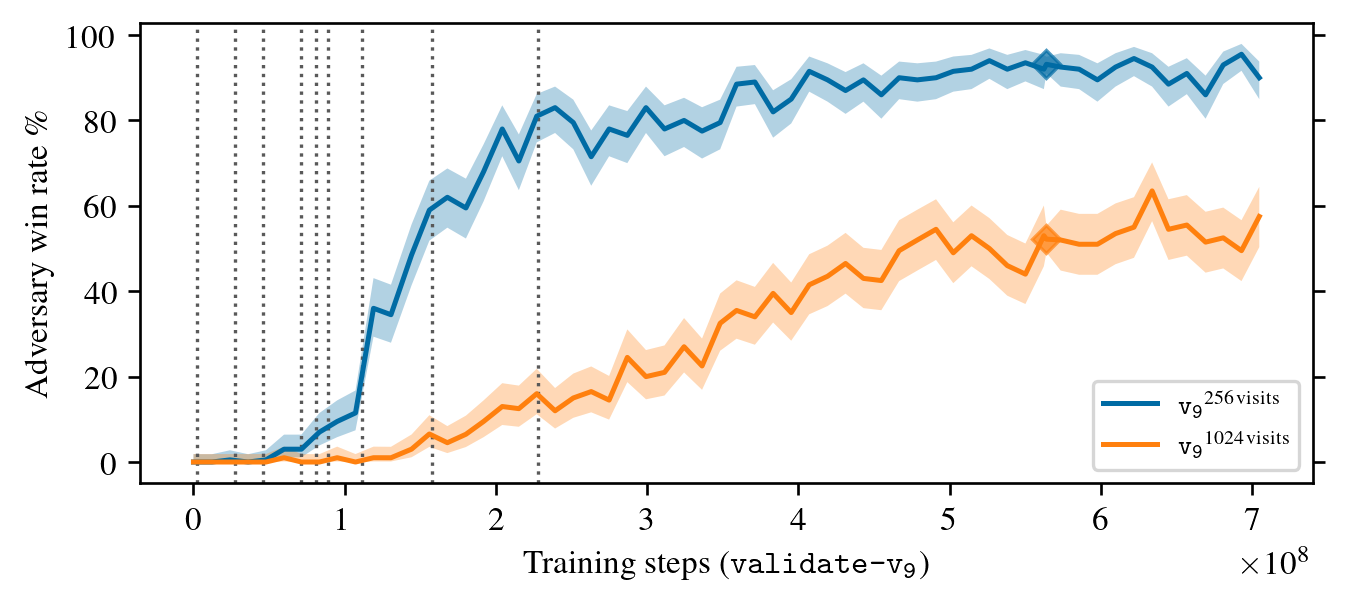

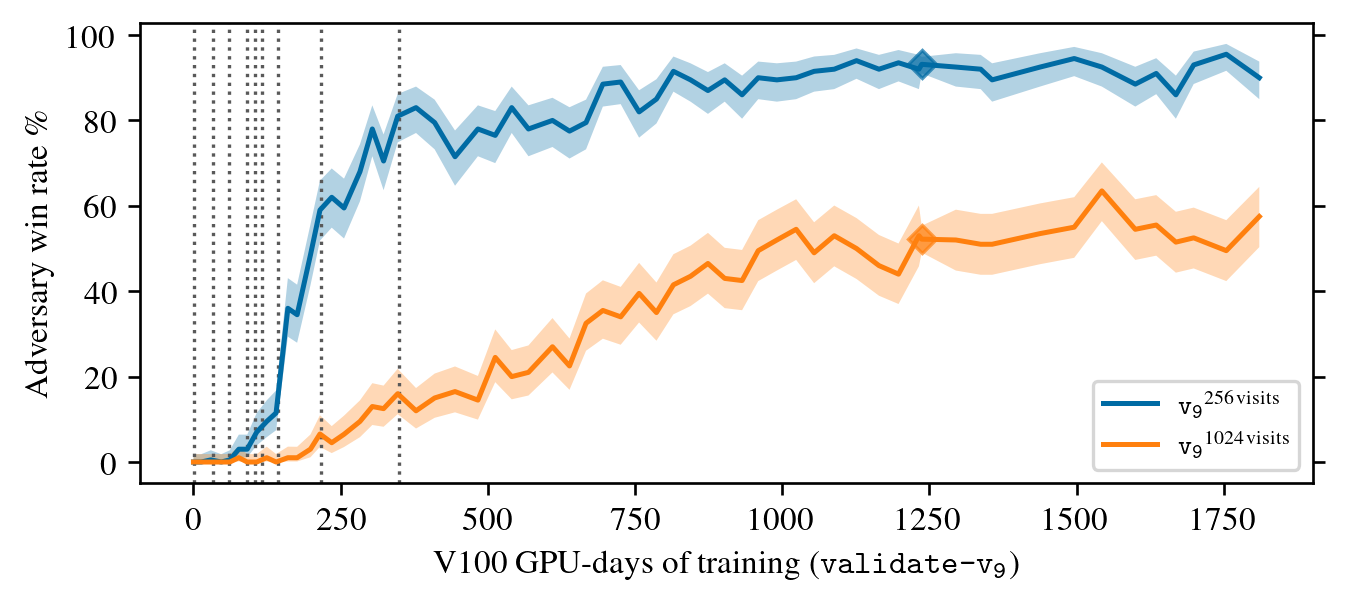

In [16]:
df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-attack-h9-sweeps-240313/adv-ckpts",
    ]
)
print("Victims:", df.victim_name.unique())
(fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = plot_win_rate_vs_gpu_days(
    df,
    [
        (Path("/shared/victimplay") / path) for path in [
            "ttseng-attack-h9-240119",
            "ttseng-attack-h9-cont-240124", 
            "ttseng-attack-h9-cont-240126",
            "ttseng-attack-h9-cont-240229",
            "ttseng-attack-h9-cont-240305",
        ]
    ],
    {
        "h9-v256": r"$\defenseiter{9}^\mathrm{256\,visits}$",
        "h9-v1024": r"$\defenseiter{9}^\mathrm{1024\,visits}$",
    },
    564026112,
    adv_name=r"\attackhnine{}",
    stop_steps = [89110272, 20176640, 494445056, 46917888],
    # Skip drawing the curriculum changes where we went to h9-v1024
    # and then reverted back to v512.
    should_skip_curriculum_change_fn=lambda step: step >= 260077824, 
)
ax_steps.legend()
ax_gpu_days.legend()
fig_steps.savefig("win-rate-vs-steps-attack-h9.pgf", backend="pgf")
fig_gpu_days.savefig("win-rate-vs-gpu-days-attack-h9.pgf", backend="pgf")

Victims: ['vit-v4096' 'vit-v256']
Curriculum ranges: [('victim-vitb16-s650025472-d167043571.p-v1', (0, 1782272)), ('victim-vitb16-s650025472-d167043571.p-v2', (1782272, 14193152)), ('victim-vitb16-s650025472-d167043571.p-v4', (14193152, 22108160)), ('victim-vitb16-s650025472-d167043571.p-v8', (22108160, 27951616)), ('victim-vitb16-s650025472-d167043571.p-v16', (27951616, 35869184)), ('victim-vitb16-s650025472-d167043571.p-v32', (35869184, 42716160)), ('victim-vitb16-s650025472-d167043571.p-v64', (42716160, 51487488)), ('victim-vitb16-s650025472-d167043571.p-v128', (51487488, 111803904)), ('victim-vitb16-s650025472-d167043571.p-v256', (111803904, 129485312)), ('victim-vitb16-s650025472-d167043571.p-v512', (129485312, 155800320)), ('victim-vitb16-s650025472-d167043571.p-v1024', (155800320, 160007936)), ('victim-vitb16-s650025472-d167043571.p-v256', (163142144, 190016768)), ('victim-vitb16-s650025472-d167043571.p-v512', (190016768, 199931136)), ('victim-vitb16-s650025472-d167043571.p-v102

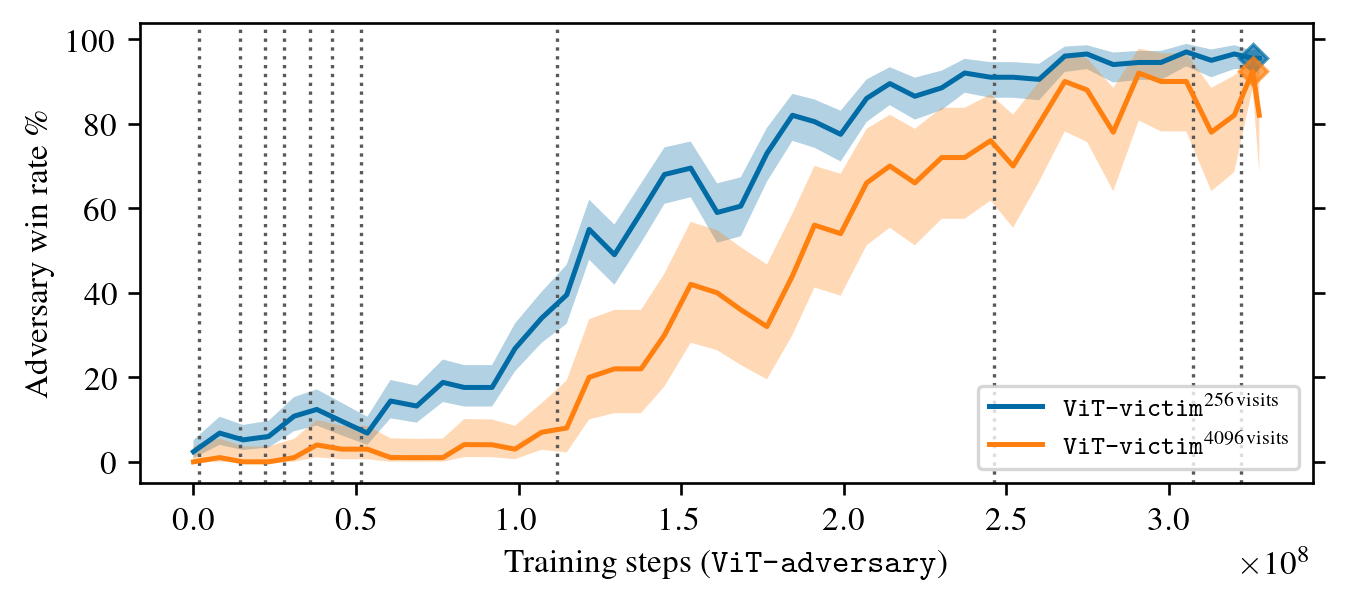

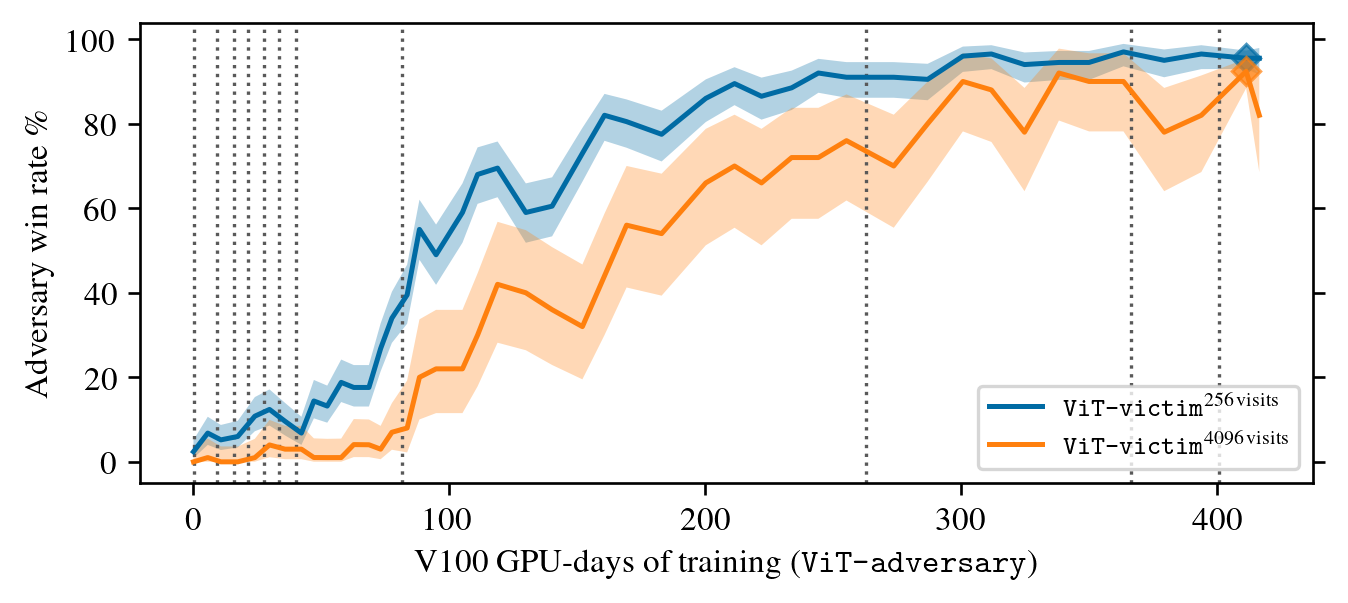

In [17]:
df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-attack-vit-sweeps-240313/adv-ckpts",
    ]
)
print("Victims:", df.victim_name.unique())
def attack_vit_scale_gpus(steps, gpu_days):
    fp32_cost = 554.5959008758527
    fp32_scalar = 0.2559663746
    if steps <= 171194368: # FP32-victimplay only
        victimplay_cost = gpu_days * fp32_scalar
    else:
        # some FP32 victimplay and some FP16 victimplay,
        # but also the FP16 victimplay was slow
        victimplay_cost = fp32_cost * fp32_scalar + (gpu_days - fp32_cost) * 0.5860573859
    training_cost = 1.751047987 * steps / 325780992
    return victimplay_cost + training_cost
(fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = plot_win_rate_vs_gpu_days(
    df,
    [
        (Path("/shared/victimplay") / path) for path in [
            "ttseng-vit-attack-240114",
            "ttseng-vit-attack-cont-240130", 
        ]
    ],
    {
        "vit-v256": r"$\vitvictim{}^\mathrm{256\,visits}$",
        "vit-v4096": r"$\vitvictim{}^\mathrm{4096\,visits}$",
    },
    325780992,
    adv_name=r"\vitadversary{}",
    stop_steps = [108951552],
    scale_gpu_days = attack_vit_scale_gpus,
    # Skip curriculum changes at which ViT moved past v256 early.
    should_skip_curriculum_change_fn=lambda step: 129000000 <= step <= 206000000,
)
ax_steps.legend(loc="lower right")
ax_gpu_days.legend(loc="lower right")
fig_steps.savefig("win-rate-vs-steps-attack-vit.pgf", backend="pgf")
fig_gpu_days.savefig("win-rate-vs-gpu-days-attack-vit.pgf", backend="pgf")

Victims: ['h1-v256' 'h1-v16']
Curriculum ranges: [('victim-ttseng-cp505-advtrain-spp082-20230728-s4066048-v128', (0, 4991232)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s7845120-v32', (4991232, 16828928)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s7845120-v64', (16828928, 43708416)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s7845120-v128', (43708416, 70021120)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s16113664-v32', (70021120, 85705728)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s16113664-v64', (85705728, 111237632)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s16113664-v128', (111237632, 113162496)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s16113664-v32', (113162496, 113162496)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s61032960-v32', (113162496, 123642368)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s61032960-v64', (123642368, 127918592)), ('victim-ttseng-cp505-advtrain-spp082-20230728-s61032960-v128', (127918592, 133054208)), ('

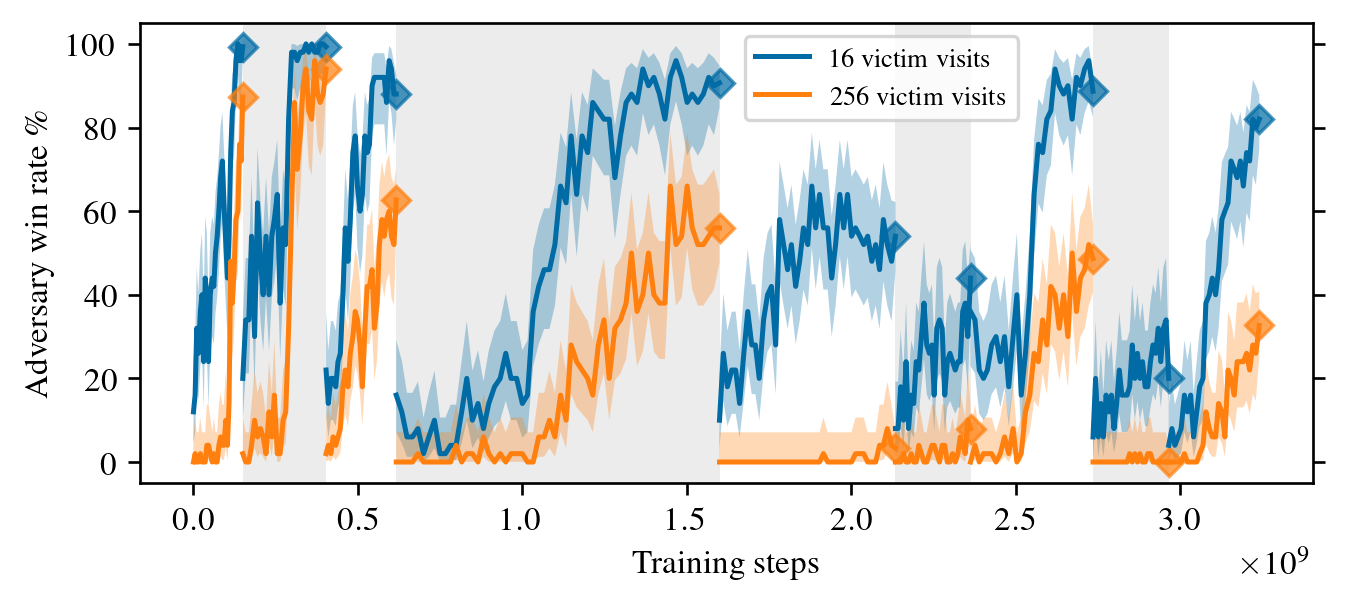

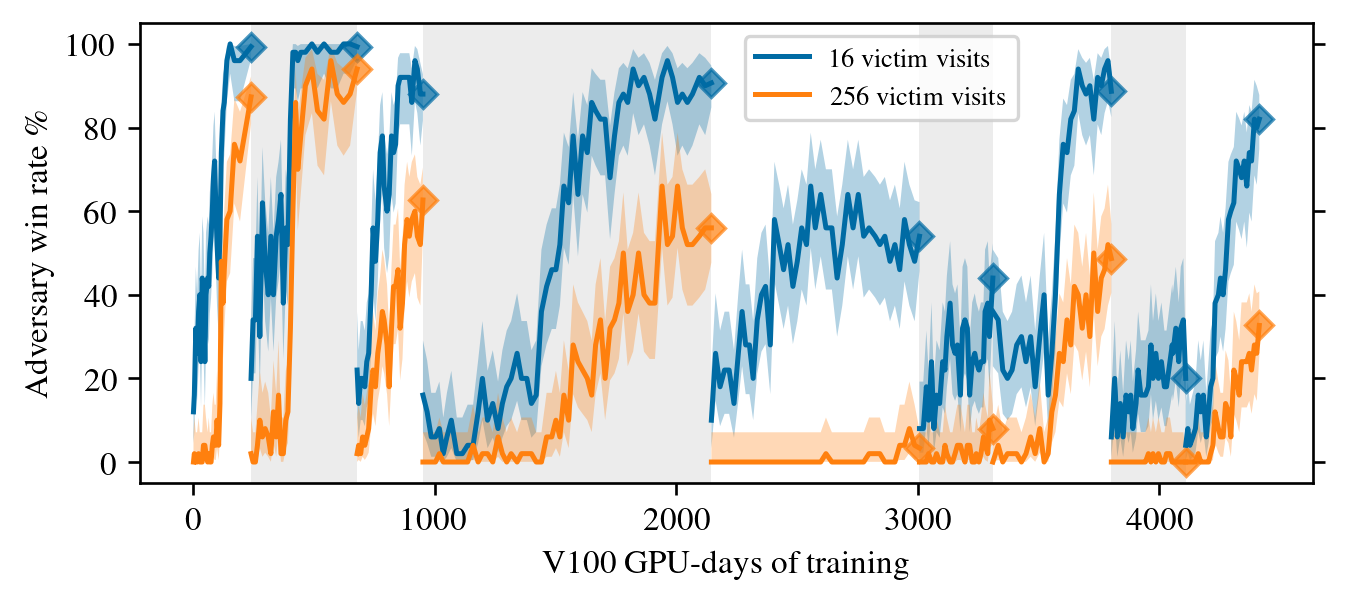

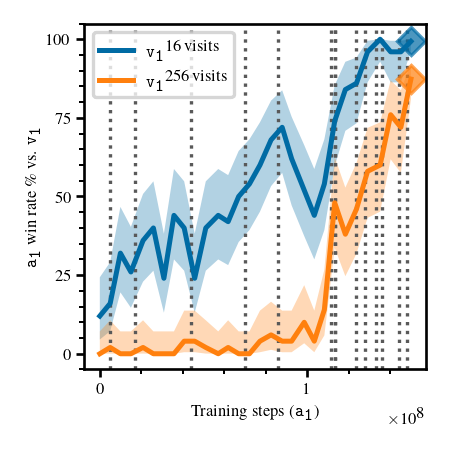

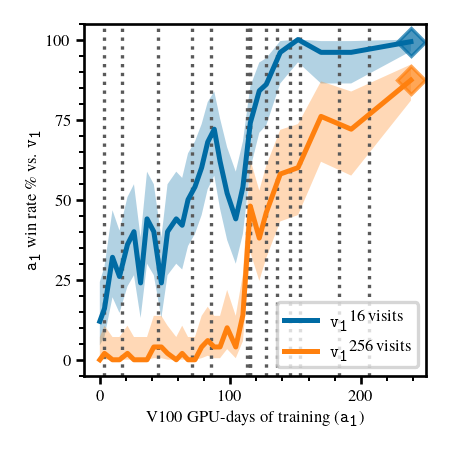

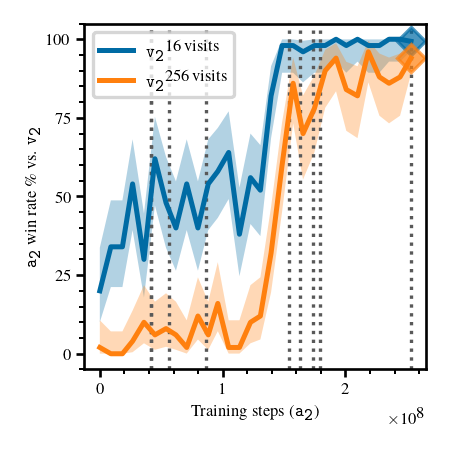

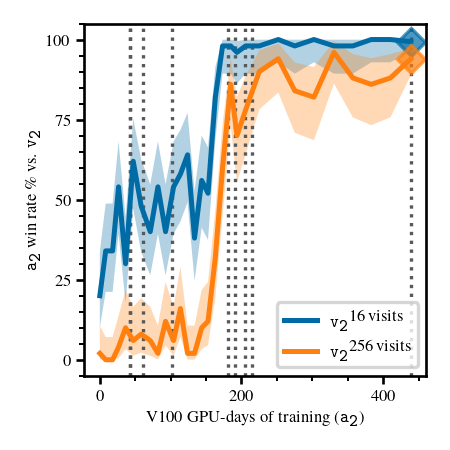

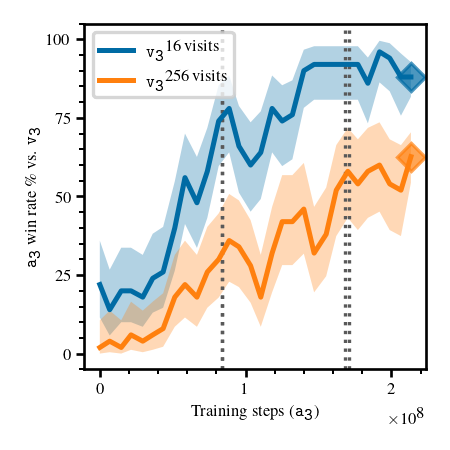

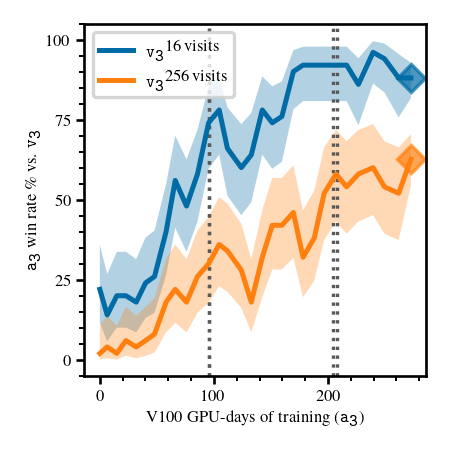

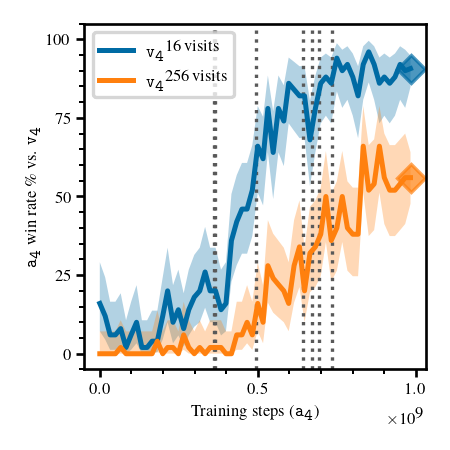

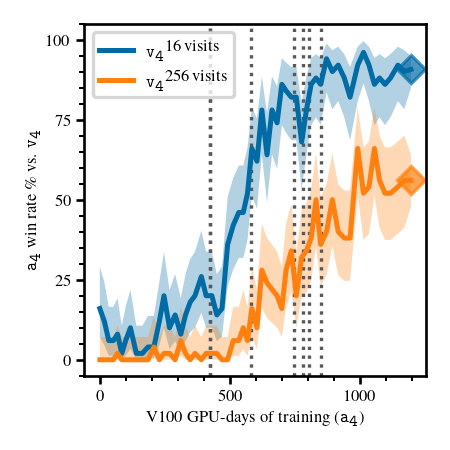

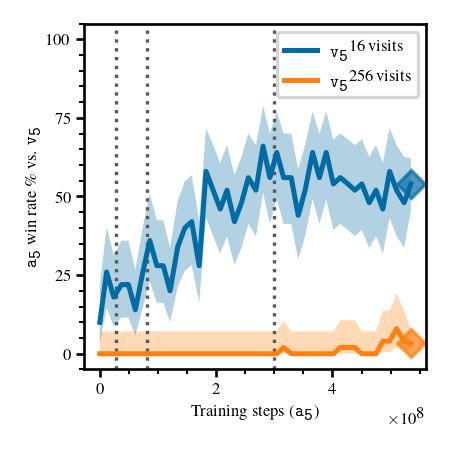

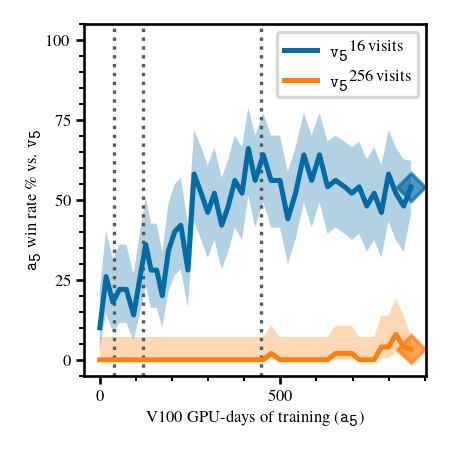

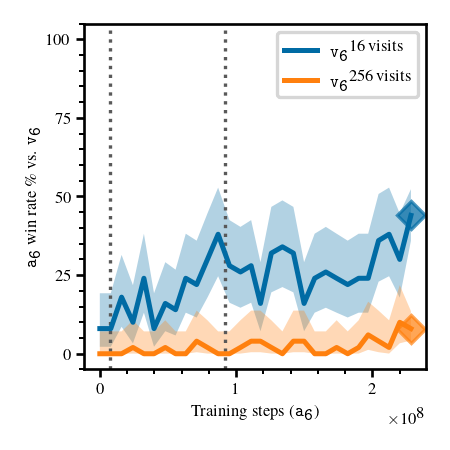

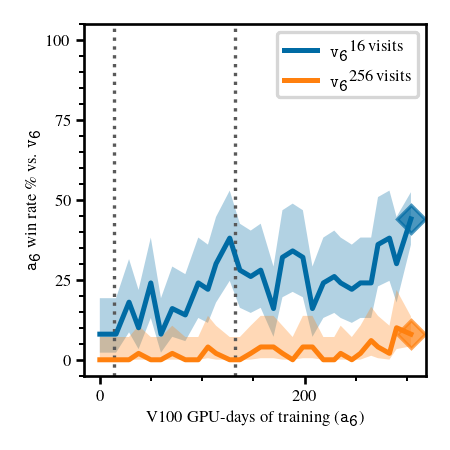

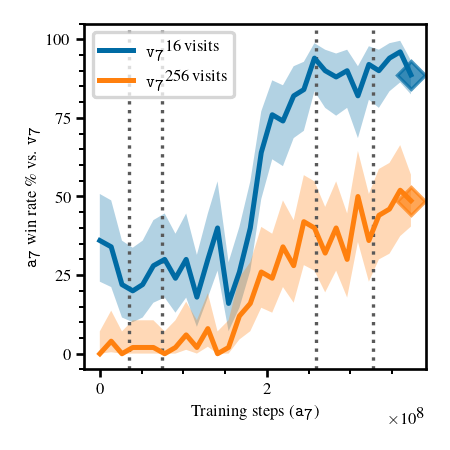

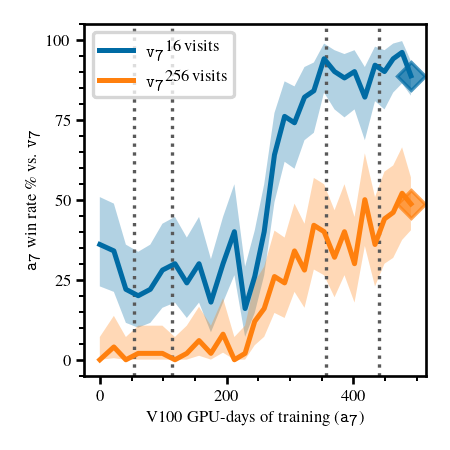

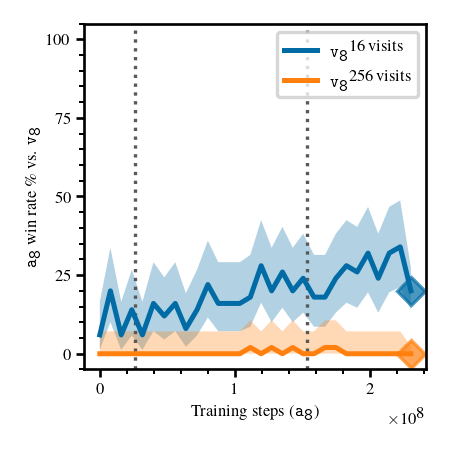

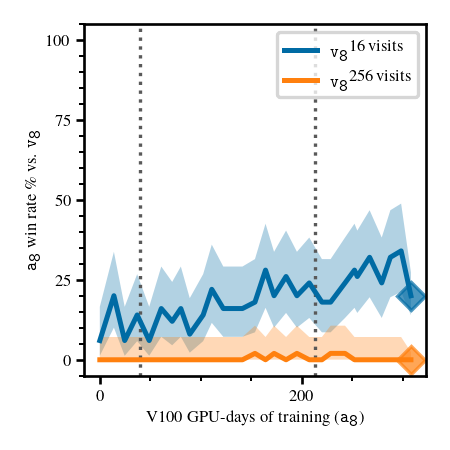

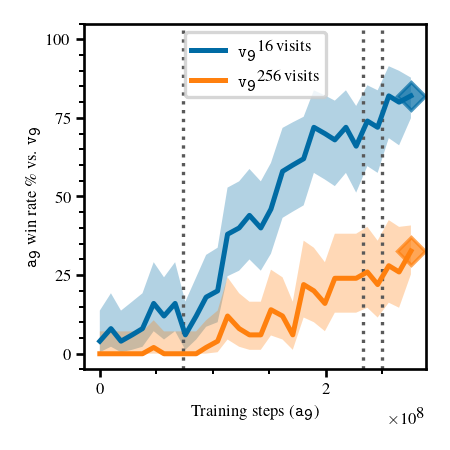

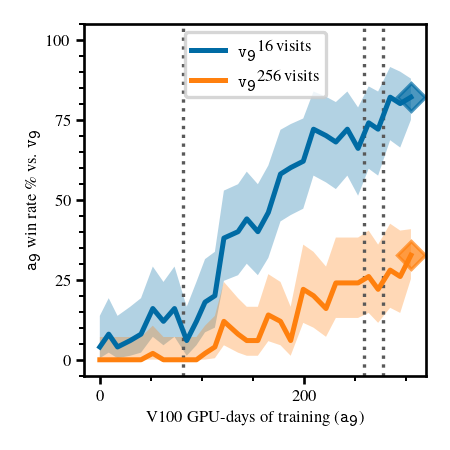

In [18]:
skip_all_fn = lambda _: True
no_skips_fn = lambda _: False
# r1--r9:
# (iter number, training paths, adv steps, stop_steps, scale_gpu_days, should_skip_curriculum_change_fn)
runs = [
    (1, ["ttseng-cyclic-reattack-20230803"], 149878784, [], 0.3390363404, no_skips_fn),
    (2, ["tony-cyclic-reattack2-20230901"], 253266688, [], 1.0, no_skips_fn),
    (3, ["ttseng-cyclic-r3-20231002", "ttseng-cyclic-r3-20231005", "ttseng-cyclic-r3-20231006-0035"], 213334016, [81496832, 11976704], 1.0, 
     # skip point at which I renamed the victim, skip point where I restarted the run and accidentally rewound curriculum back to the beginning
     lambda x: x == 64524800 or 93000000 <= x <= 96000000
    ), 
    (4, ["ttseng-cyclic-r4-20231010"], 982983936, [], 1.0,
     # skip points at which I rewound curriculum
     lambda x: x <= 360000000
    ),
    (5, ["ttseng-cyclic-r5-20231123"], 534912256, [], 1.0, no_skips_fn),
    (6, ["ttseng-cyclic-r6-20231213"], 228355840, [], 1.0, no_skips_fn),
    (7, ["ttseng-cyclic-r7-20231219"], 372472576, [], 1.0, no_skips_fn),
    (8, ["ttseng-cyclic-r8-20231231"], 230162176, [], 1.0, no_skips_fn),
    (9, ["ttseng-cyclic-r9-20240119"], 275431168, [], 1.0, no_skips_fn),
]
victim_visits = [16, 256]
# Plot containing all runs concatenated
combined_figs = None

for i, training_paths, adv_steps, stop_steps, scale_gpu_days, should_skip_curriculum_change_fn in runs:
    run_name = f"r{i}"
    adv_label = rf"\attackiter{{{i}}}"
    victim_name = f"h{i}"
    victim_label = rf"\defenseiter{{{i}}}"
    df = utils.parse_sgfs(
        [
            f"/shared/match/ttseng-iterated-adv-train-sweeps-240312/{run_name}",
        ]
    )
    print("Victims:", df.victim_name.unique())
    training_paths = [
        (Path("/shared/victimplay") / path) for path in training_paths
    ]
    victims = {
        f"{victim_name}-v{v}": rf"${victim_label}^\mathrm{{{v}\,visits}}$"
        for v in victim_visits
    }
    
    combined_figs = plot_win_rate_vs_gpu_days(
        df=df,
        training_paths=training_paths,
        victim_name_to_plot_label=victims,
        highlighted_point_step=adv_steps,
        adv_name=adv_label,
        stop_steps=stop_steps,
        scale_gpu_days=scale_gpu_days,
        # for the combined plot, having curriculum change lines is too noisy
        should_skip_curriculum_change_fn=skip_all_fn,
        existing_figs=combined_figs,
        data_background_color=("0.925" if i % 2 == 0 else None),
        verbose=False,
    )
    
    with plt.style.context(three_column_style):
        (fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = plot_win_rate_vs_gpu_days(
            df=df,
            training_paths=training_paths,
            victim_name_to_plot_label=victims,
            highlighted_point_step=adv_steps,
            adv_name=adv_label,
            stop_steps=stop_steps,
            scale_gpu_days=scale_gpu_days,
            should_skip_curriculum_change_fn=should_skip_curriculum_change_fn,
            y_label=rf"{adv_label} win rate \% vs. {victim_label}"
        )
        for ax in [ax_steps, ax_gpu_days]:
            ax.legend()
            ax.set_ylim([-5, 105])
    fig_steps.savefig(f"win-rate-vs-steps-{run_name}.pgf", backend="pgf")
    fig_gpu_days.savefig(f"win-rate-vs-gpu-days-{run_name}.pgf", backend="pgf")

(fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = combined_figs
for ax in [ax_steps, ax_gpu_days]:
    # We don't want legend entries for each plotted line, just keep two legend entries
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:2], labels=[f"{v} victim visits" for v in victim_visits], loc="upper right", bbox_to_anchor=(.76, 1))
ax_steps.set_xlabel(f"Training steps")
ax_gpu_days.set_xlabel(f"V100 GPU-days of training")
fig_steps.savefig(f"win-rate-vs-steps-r-all.pgf", backend="pgf")
fig_gpu_days.savefig(f"win-rate-vs-gpu-days-r-all.pgf", backend="pgf")

Opponents: ['r0-v600']
Curriculum ranges: [('0-s0-d0-v300', (0, 0)), ('victim-cyclic-adv-s545065216-v600', (0, 61032960)), ('0-s1069312-d108621833-v300', (1069312, 1069312)), ('0-s2139392-d108716292-v300', (2139392, 2139392)), ('0-s3067392-d108989510-v300', (3067392, 3067392)), ('0-s4066048-d109192193-v300', (4066048, 4066048)), ('0-s4992000-d109448047-v300', (4992000, 4992000)), ('0-s5919488-d109695062-v300', (5919488, 5919488)), ('0-s6846464-d110008854-v300', (6846464, 6846464)), ('0-s7845120-d110174950-v300', (7845120, 7845120)), ('0-s8843008-d110453096-v300', (8843008, 8843008)), ('0-s9769728-d11067127-v300', (9769728, 9769728)), ('0-s10838784-d110976447-v300', (10838784, 10838784)), ('0-s11909632-d111164244-v300', (11909632, 11909632)), ('0-s12977664-d111499426-v300', (12977664, 12977664)), ('0-s14046464-d111673247-v300', (14046464, 14046464)), ('0-s15044096-d111963943-v300', (15044096, 15044096)), ('0-s16113664-d11221612-v300', (16113664, 16113664)), ('0-s17114112-d112481685-v300

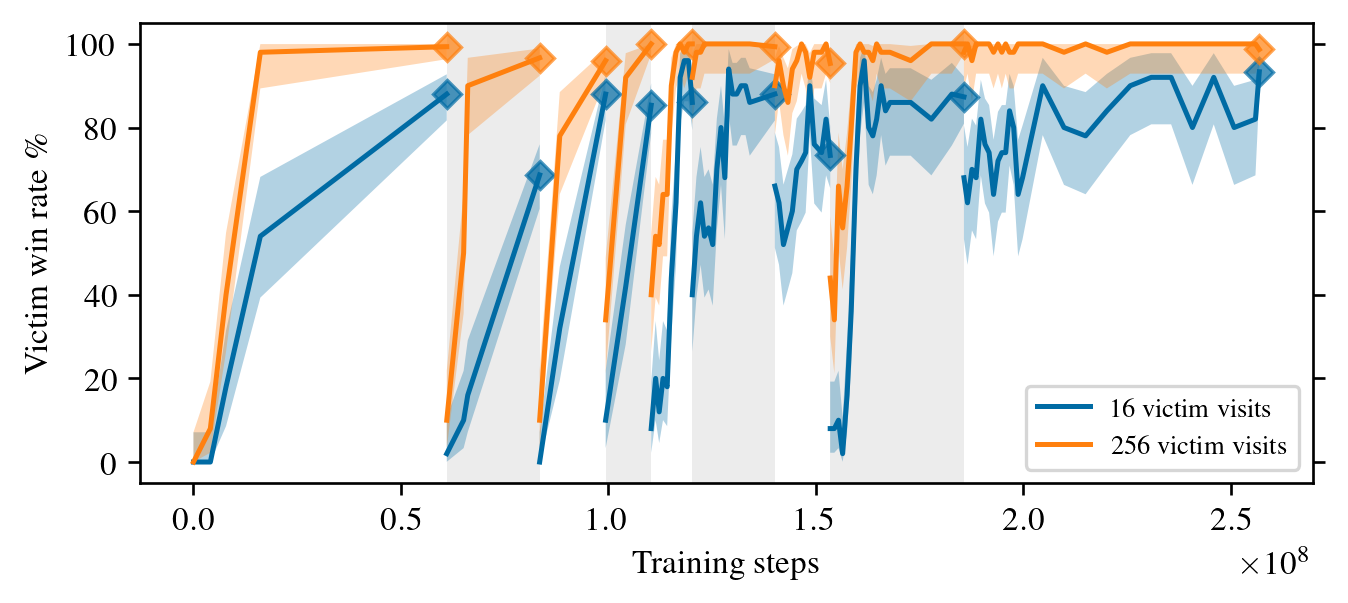

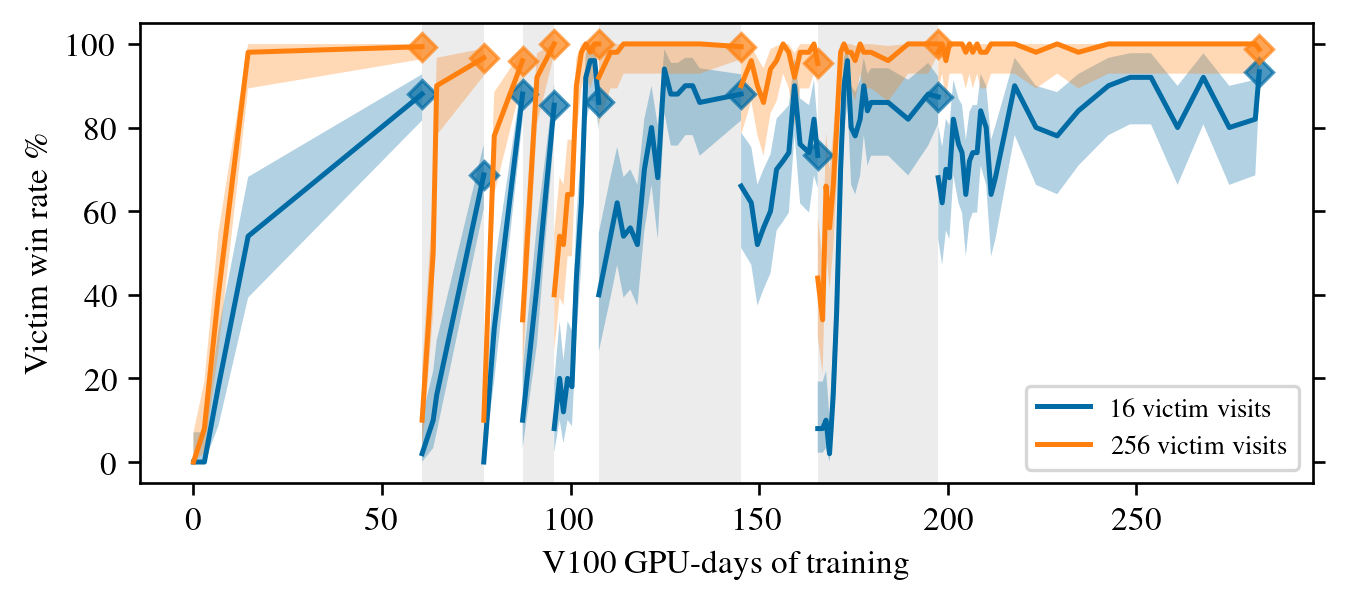

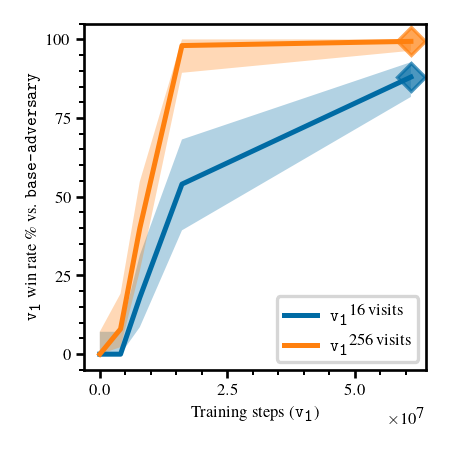

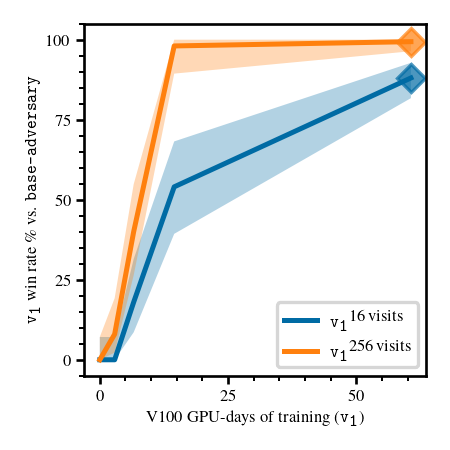

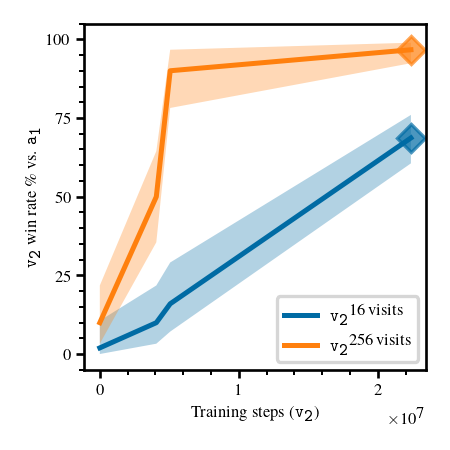

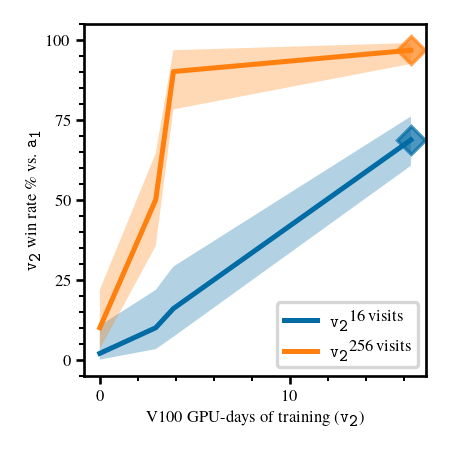

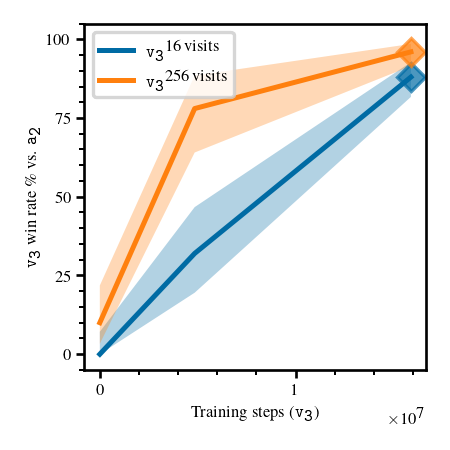

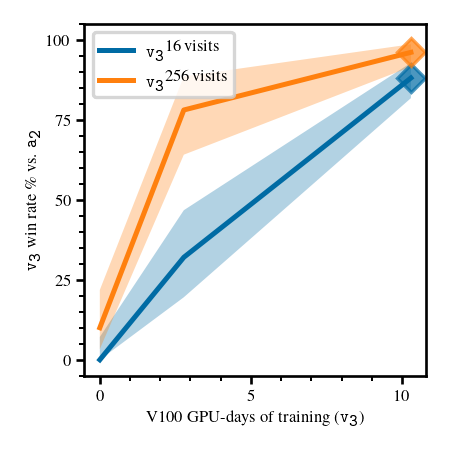

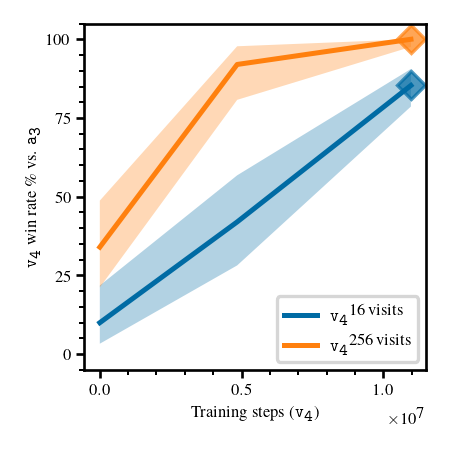

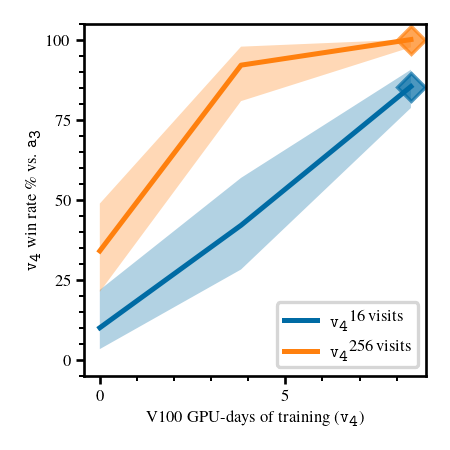

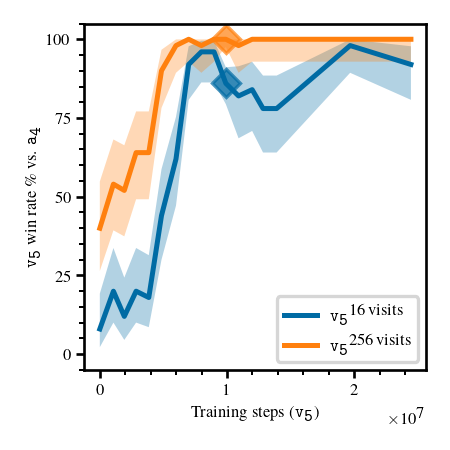

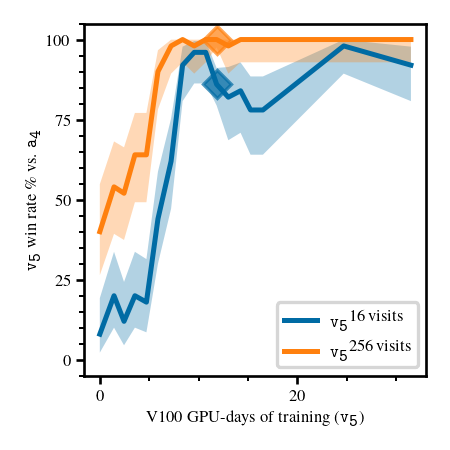

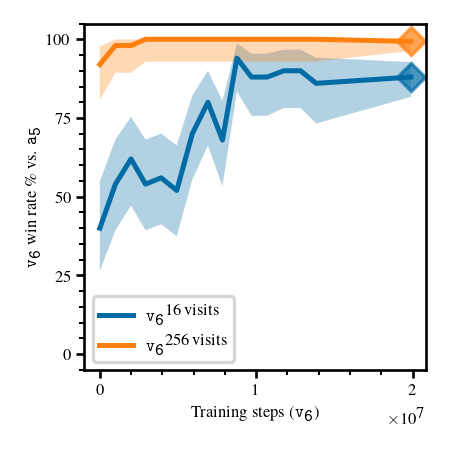

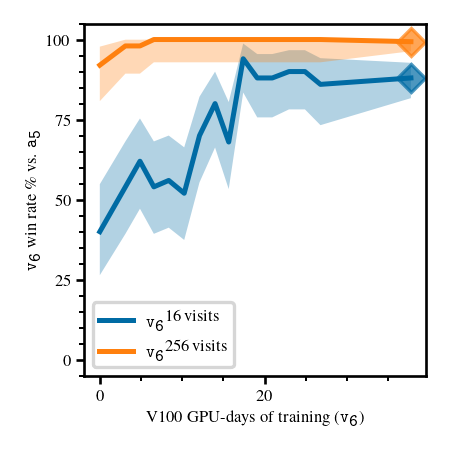

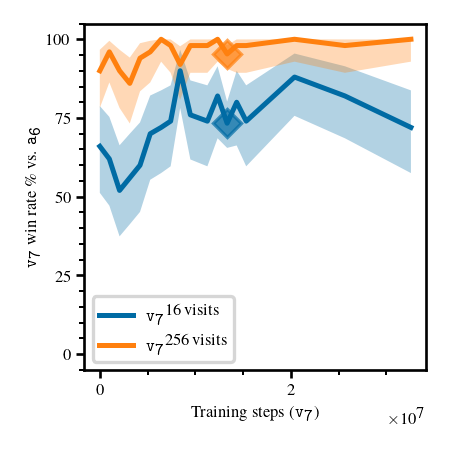

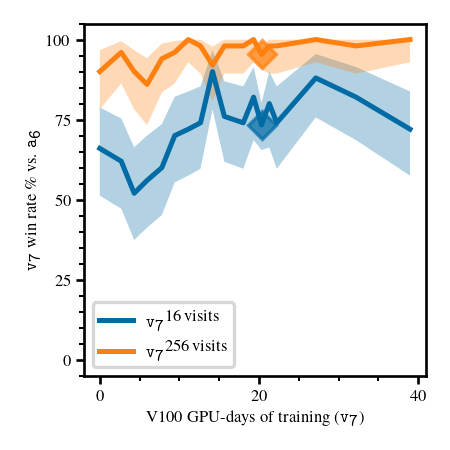

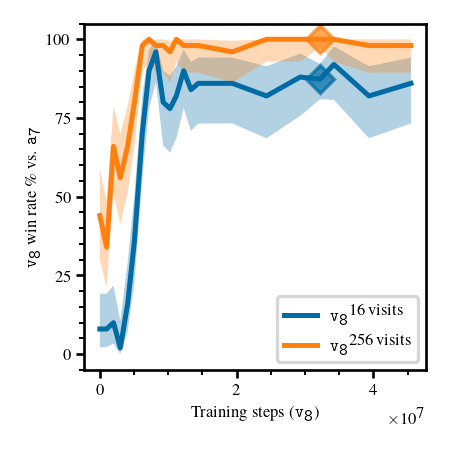

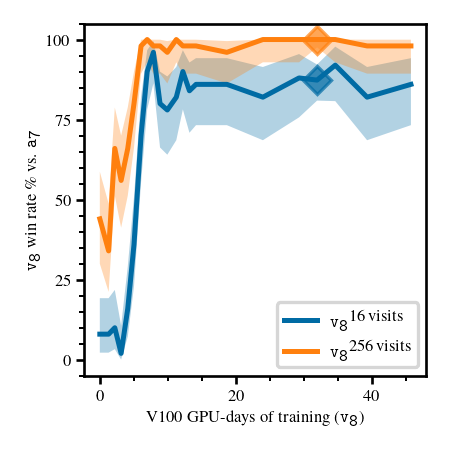

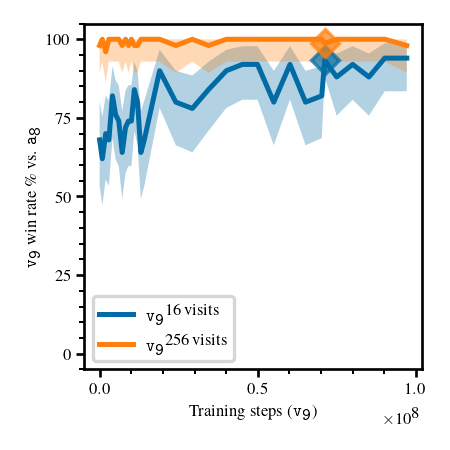

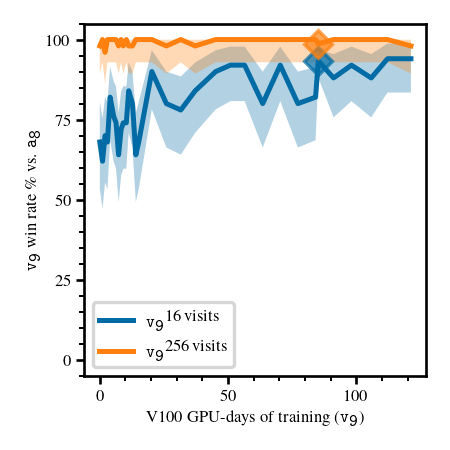

In [19]:
# h1--h9:
# (iter number, training path, victim steps, scale_gpu_days)
runs = [
    (1, "ttseng-cp505-advtrain-spp082-lr01-20230728-170008", 61032960, 1.071153355),
    (2, "ttseng-cp505-h2-20230823-142646", 22387200, 1.10002934),
    (3, "ttseng-cp505-h3-retry-20230921-202435", 15898624, 1.114952937),
    (4, "ttseng-cp505-h4-20231009-143230", 10979072, 1.096516887),
    (5, "ttseng-cp505-h5-20231121", 9905920, 1.0),
    (6, "ttseng-cp505-h6-fix-20231212", 19897600, 1.0),
    (7, "ttseng-cp505-h7-20231218", 13333248, 1.0),
    (8, "ttseng-cp505-h8-20231229", 32231168, 1.0), 
    (9, "ttseng-cp505-h9-240113", 71170048, 1.0),
]
# Plot containing all runs concatenated
combined_figs = None

for i, training_path, steps, scale_gpu_days in runs:
    # We're scaling GPU-days for the runs where we lost Hofvarpnir data:
    # timestamps can't be trusted, and we don't have training logs anymore.
    trust_last_modified_timestamps = scale_gpu_days == 1.0
    skip_train_compute = scale_gpu_days != 1.0
    
    run_name = f"h{i}"
    victim_label = rf"\defenseiter{{{i}}}"
    adv_name = f"r{i-1}"
    adv_label = r"\origcyclic{}" if i == 1 else rf"\attackiter{{{i - 1}}}"
    df = utils.parse_sgfs(
        [
            f"/shared/match/ttseng-iterated-adv-train-sweeps-240312/h/{run_name}",
        ]
    )
    df_prefix = df[df.adv_steps <= steps]
    print("Opponents:", df.victim_name.unique())
    training_paths = [ Path("/shared/victimplay/") / training_path / "iteration-0" ]
    advs = {
        f"{adv_name}-v600": adv_label,
    }

    combined_figs = plot_win_rate_vs_gpu_days(
        df=df_prefix,
        training_paths=training_paths,
        victim_name_to_plot_label=advs,
        highlighted_point_step=steps,
        adv_name=victim_label,
        scale_gpu_days=scale_gpu_days,
        should_skip_curriculum_change_fn=lambda _: True,
        y_label=rf"Victim win rate \%",
        trust_last_modified_timestamps=trust_last_modified_timestamps,
        skip_train_compute=skip_train_compute,
        existing_figs=combined_figs,
        data_background_color=("0.925" if i % 2 == 0 else None),
        verbose=False,
    )

    with plt.style.context(three_column_style):
        (fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = plot_win_rate_vs_gpu_days(
            df=df,
            training_paths=training_paths,
            victim_name_to_plot_label=advs,
            highlighted_point_step=steps,
            adv_name=victim_label,
            scale_gpu_days=scale_gpu_days,
            # Skip drawing all curriculum lines, there's no curriculum here and the game
            # parsing logic for determining curriculum changes doesn't work properly for
            # this kind of training run.
            should_skip_curriculum_change_fn=lambda _: True,
            y_label=rf"{victim_label} win rate \% vs. {adv_label}",
            trust_last_modified_timestamps=trust_last_modified_timestamps,
            skip_train_compute=skip_train_compute,
        )
        for ax in [ax_steps, ax_gpu_days]: 
            ax.legend()
            ax.set_ylim([-5, 105])
    fig_steps.savefig(f"win-rate-vs-steps-{run_name}.pgf", backend="pgf")
    fig_gpu_days.savefig(f"win-rate-vs-gpu-days-{run_name}.pgf", backend="pgf")

(fig_steps, ax_steps), (fig_gpu_days, ax_gpu_days) = combined_figs
victim_visits = [16, 256]
for ax in [ax_steps, ax_gpu_days]:
    # We don't want legend entries for each plotted line, just keep two legend entries
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:2], labels=[f"{v} victim visits" for v in victim_visits], loc="lower right", bbox_to_anchor=(1, 0))
ax_steps.set_xlabel(f"Training steps")
ax_gpu_days.set_xlabel(f"V100 GPU-days of training")
fig_steps.savefig(f"win-rate-vs-steps-h-all.pgf", backend="pgf")
fig_gpu_days.savefig(f"win-rate-vs-gpu-days-h-all.pgf", backend="pgf")